<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install miceforest

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.9 MB/s eta 0:00:00


In [ ]:
pip install gcimpute

In [5]:
import miceforest as mf
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

d = 6
n = 20
print("ciao ")
x = np.random.randint(low=0, high=100, size=(n, d))
x = pd.DataFrame(x)
x.columns = x.columns.astype(str)
print(x)



ciao 
     0   1   2   3   4   5
0   52  41  84  38   7  73
1   53  13  75  34  90  19
2   31  71  25  44   5  35
3   96  78  69  76  82  96
4   98  80  53  41  87  47
5   68  48  38  47  52  58
6   66  64   5  53   4  13
7   24  70  40  35  59  78
8   11  32  43  11   4  78
9   55  12  55  29  18  34
10  48  86  14  14  29  26
11  81  29  78  53   2  74
12  84  22  89  36  73  72
13  41  18  48   6  72  36
14  49  29  59  34  23   6
15  76  59  96  47  57  16
16  76  18  22  88  68  59
17  85  80  30  11   4  94
18  54  70  83  74  30  52
19  14  11  17  76  71  53


In [1]:
from re import VERBOSE
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import ridge_regression
import tqdm
import cvxpy as cp
print(cp.installed_solvers())
import numpy as np
import copy

import traceback


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_dict, p):  # S is the matrix such that ||S^(-1) @ Dx||\leq delta. As a consequence, S appears in the unconstrained problem
        # S: (d, d) matrix, or S = np.concatenate(tS), with tS = [S1,..,S_m], so S is (d * n, d)
        n, d = X.shape
        q = compute_q(p)

        #print("who is X", X)
        #print("who is y", y)
        #print("who is S", S)
        #print("who is q in AdversarialTraining: ", q)
        #Formulate problem
        param = cp.Variable(d)
        #print("shape param ", param.shape)
        #print("dim ", n)
        print("X ", n," ", d)
        print("y shape", y.shape)
        #print("S_dict ", S_dict)
        #print("S in adv training", S)
        print("nm ", d*n)
        S_dts = S_dict['S_dts']
        S_mis = S_dict['S_mis']
        adv_radius_times_scale_dts = cp.Parameter(name='adv_radius_times_dts', nonneg=True)
        adv_radius_times_scale_mis = cp.Parameter(name='adv_radius_times_mis', nonneg=True)
        #scale_dts = cp.Parameter(name='scale_dts', nonneg=True)
        #scale_mis = cp.Parameter(name='scale_mis', nonneg=True)
        print("S_mis in Adbvt training ", S_mis)
        #if np.sum(S_mis * S_mis) == 0:
        if np.all(S_dict['S_mis'] == 0):
          print("no missing part")
          S = S_dts * adv_radius_times_scale_dts
        else:  # S_mis.shape == (n, d, d):
          S_dts_tiled = np.concatenate([S_dts] * n)
          S_mis_conc = np.concatenate(S_mis)
          #np.concatenate([yyy] * 2)
          S = S_dts_tiled * adv_radius_times_scale_dts + S_mis_conc * adv_radius_times_scale_mis
          print("S type ", type(S))
          #S = np.concatenate(S)
          print("S is a tensor, concatenated")
          print("final S after conc \n", S)

        if S.shape == (d, d):
          print("one matrix in input, S.shape = (n, n)")
          partial = S @ param  # should be (m * n,)
          param_norm = cp.pnorm(partial, p=q)
        elif S.shape == (d * n, d):  # should be a stack of matrices
          print("multiple matrices in input, S conc")
          partial = S @ param  # should be (m * n,)
          partial = cp.reshape(partial, (n, d), order='C')
          param_norm = cp.pnorm(partial, p=q, axis=1)
        else:
          print("--------> ERROR: NO MATRIX S FOUND IN ADVERSARIAL TRAINING")
        #elif S.shape == (m , n):  # stack of diagonal matrices
        #  print("multiple matrices in input, S_i diag")
          #S_cvx = cp.Constant(S)
        #  partial = cp.multiply(cp.Parameter(S), param)
        #  param_norm = cp.pnorm(partial, p=q, axis=1)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / n * cp.sum((abs_error + param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius_times_scale_dts = adv_radius_times_scale_dts
        self.adv_radius_times_scale_mis = adv_radius_times_scale_mis
        #self.scale_dts = scale_dts
        #self.scale_mis = scale_mis
        self.param = param
        self.warm_start = False


    def __call__(self, dict_hyper_p, **kwargs):
        try:
            #print("dic thyper p ", dict_hyper_p)
            self.adv_radius_times_scale_dts.value = dict_hyper_p['adv_radius_times_dts']
            self.adv_radius_times_scale_mis.value = dict_hyper_p['adv_radius_times_mis']
            #self.scale_dts.value = dict_hyper_p['scale_dts
            #self.scale_mis.value = dict_hyper_p['scale_mis']
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v

'''
    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v
'''


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []

# dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'eps_adv_rad_times_delta_dts': 1e-4 'eps_adv_rad_times_delta_dts': 1e-4}}
def get_path(X, y, estimator, S_dict): #eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
    _, m = X.shape

    if S_dict['algo_superv_learn'] == 'adv':
      #n_a_dts = S_dict['n_a_dts']
      #a_d_dts_max = S_dict['adv_rad_times_delta_dts_max']
      #a_d_dts_min = a_d_dts_max * S_dict['eps_adv_rad_times_delta_dts']

      if np.all(S_dict['S_dts'] == 0):
        n_a_dts, a_d_dts_max, a_d_dts_min = 1, 0, 0
      else:
        n_a_dts = S_dict['n_a_dts']
        a_d_dts_max = S_dict['adv_rad_times_delta_dts_max']
        a_d_dts_min = a_d_dts_max * S_dict['eps_adv_rad_times_delta_dts']

      if np.all(S_dict['S_mis'] == 0):
        n_a_mis, a_d_mis_max, a_d_mis_min = 1, 0, 0
      else:
        n_a_mis = S_dict['n_a_mis']
        a_d_mis_max = S_dict['adv_rad_times_delta_mis_max']
        a_d_mis_min = a_d_mis_max * S_dict['eps_adv_rad_times_delta_mis']


      if a_d_dts_max < 0 or a_d_mis_max < 0 or n_a_dts < 1 or n_a_mis <1:
        print("WARNING: some bad values for the grid of cross validation, the number of grid point should be strictly potive, the radius strictly positive")
      alphas_dts = np.logspace(np.log10(a_d_dts_min), np.log10(a_d_dts_max), n_a_dts) if a_d_dts_max > 0 else np.zeros(1)
      alphas_mis = np.logspace(np.log10(a_d_mis_min), np.log10(a_d_mis_max), n_a_mis) if a_d_mis_max > 0 else np.zeros(1)
      #alphas_dts = np.logspace(np.log10(a_d_dts_min), np.log10(a_d_dts_max), n_a_dts)
      #alphas_mis = np.logspace(np.log10(a_d_mis_min), np.log10(a_d_mis_max), n_a_mis)
      print("dts deltas ", alphas_dts)
      print("mis deltas ", alphas_mis)
      #hyper_p = {'scale_dts': dts_deltas, 'scale_mis': mis_deltas}
      hyper_p_ret_ = []
      coefs_ = []
      for a_mis_value in tqdm.tqdm(alphas_mis):
        for a_dts_value in tqdm.tqdm(alphas_dts):
            #tuple_key = (scale_dts_value, scale_mis_value)
            #coefs_ = []
            #for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_dts': a_dts_value, 'adv_radius_times_mis': a_mis_value}
              #print("dict hyper in get path ", dict_hyper_p_values)
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a_dts_value, a_mis_value])
            #res[tuple_key] = np.stack((coefs_)).T
    elif S_dict['algo_superv_learn'] == 'ridge':
      n_a_rid = S_dict['n_a_rid']
      a_rid_max = S_dict['alpha_ridge_reg_max']
      a_rid_min = a_rid_max * S_dict['eps_alpha_ridge_reg']
      alphas_rid = np.logspace(np.log10(a_rid_min), np.log10(a_rid_max), n_a_rid) if a_rid_max > 0 else np.zeros(1)
      print("rid alphas ", alphas_rid)
      hyper_p_ret_ = []
      coefs_ = []
      print("S_dts_inv in get path, ridge regression \n", S_dict['S_dts'])
      S_dts_inv = np.linalg.inv(S_dict['S_dts'])  # (d, d)
      print("S_dts_inv in get path, ridge regression \n", S_dts_inv)
      for a_rid in tqdm.tqdm(alphas_rid):
            #dict_hyper_p_values = {'adv_radius_times_dts': a_dts_value, 'adv_radius_times_mis': a_mis_value}
            #print("dict hyper in get path ", dict_hyper_p_values)
            coefs = estimator(X @ S_dts_inv, y, a_rid)
            coefs = S_dts_inv @ coefs
            print("alpha  ", a_rid, "coef_ridge: ", coefs)
            coefs_.append(coefs if coefs is not None else np.zeros(m))
            hyper_p_ret_.append([a_rid, 0])  #([a_dts_value, a_mis_value])


    '''
    for scale_dts_value in tqdm.tqdm(dts_deltas):
        for scale_mis_value in tqdm.tqdm(mis_deltas):
          #tuple_key = (scale_dts_value, scale_mis_value)
          #coefs_ = []
          for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_scale_dts': a * scale_dts_value, 'adv_radius_times_scale_mis': a * scale_mis_value}
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a, scale_dts_value, scale_mis_value])
          #res[tuple_key] = np.stack((coefs_)).T
    '''
    return np.stack((hyper_p_ret_)).T, np.stack((coefs_)).T

#dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'alpha_ridge_reg': 1,
#                             'eps_adv_rad_times_delta_dts': 1e-4, 'eps_adv_rad_times_delta_mis': 1e-4, 'eps_alpha_ridge_reg': 1e-4,
#                             'n_a_dts': 25, 'n_a_mis':4, 'n_a_rid': 25}}





'''
def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        #print("alpha  ", a, "coef: ", coefs)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T
'''


def plot_coefs(alphas, coefs, ax):
    #print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).sum(axis=0)
    ax.set_xlabel("1/alphas")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.semilogx(1/alphas, l1norm, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    #print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).mean(axis=0)
    l1norm = np.abs(coefs).sum(axis=0)
    #print("coef ", coefs)
    #print("l1norm ", l1norm)
    ax.set_xlabel("l1norm")
    ax.set_ylabel("coef")


    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)


def train_and_plot(X, y, S_dict, list_ax):

    if S_dict['algo_superv_learn'] == 'adv':
      linfadvtrain = AdversarialTraining(X, y, S_dict, p=np.inf)
      estimator = lambda X, y, dic_h:  linfadvtrain(dict_hyper_p=dic_h)
      hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, S_dict)
    elif S_dict['algo_superv_learn'] == 'ridge':
      estimator = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=False)#, random_state=0)
      hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, S_dict)
      #estimator = lambda X, y, a: linear_model.Ridge(alpha=a).fit(X, y).coef_
    #print("hyper_p used\n ", hyper_p)
    if len(list_ax) > 0:
      plot_coefs_l1norm(coefs_advtrain_linf, list_ax[0])
      plot_coefs(alphas_adv, coefs_advtrain_linf, list_ax[1])
    return hyper_p, coefs_advtrain_linf


X = np.random.randn(100, 4) #rng.randn(100, 4)

y = 2.0 * X[:, 0] - 1.0 * X[:, 1] + 0.1 * np.random.randn(100)

alphas = [0.00001, 0.001, 0.1, 1]
estim = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=True, random_state=0)
for a in alphas:
  coef, intercept = estim(X, y, a)
  print("coef : ", coef)
  print("intercpt ", intercept)
  coef, intercept = ridge_regression(X, y, alpha=a, return_intercept=True, random_state=0)
  print("coef : ", coef)
  print("intercpt ", intercept)


'''
def add_rectangles_old(x, y, box_width, box_height, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)

  for xi, yi in zip(x[r_c], y[r_c]):
      rect = patches.Rectangle(
        (xi-box_width/2, yi-box_height/2),
        box_width, box_height,
        linewidth=1, edgecolor='r', facecolor='none'
      )
      ax.add_patch(rect)
'''

def add_rectangles(x, y, S, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)
  d = S.shape[-1]
  #S = S * 100
  if S.ndim == 2 or S.shape == (1, d, d):
    S = S.squeeze()
    print("------------------------> who is S in add_rectangles\n", S)
    box_width = S[0, 0]
    box_height = S[1, 1]
    for xi, yi in zip(x[r_c], y[r_c]):
        rect = patches.Rectangle(
          (xi-box_width/2, yi-box_height/2),
          box_width, box_height,
          linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
  else:  # S is something like (n, d, d)
    #print("---------------> who is S in add_rectangles (mult imp)\n", S)
    box_width = S[:, 0, 0]
    box_height = S[:, 1, 1]
    #print("bw\n ", box_width)
    #print("bh\n ", box_height)
    #print("------------------------------> boxes printed")
    for xi, yi, bw, bh in zip(x[r_c], y[r_c], box_width[r_c], box_height[r_c]):
        #print("bw, bh ", bw, ",   ", bh)
        rect = patches.Rectangle(
          (xi-bw/2, yi-bh/2),
          bw, bh, linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
    ax.set_aspect('equal')



print("end block")


['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']
coef :  [ 2.01712913 -1.00896199  0.00205178  0.0064306 ]
intercpt  -8.728417588521488e-05
coef :  [ 2.01712913 -1.00896199  0.00205178  0.0064306 ]
intercpt  -8.728417588521488e-05
coef :  [ 2.01710538 -1.00895256  0.00204743  0.00643061]
intercpt  -8.489022581145063e-05
coef :  [ 2.01710538 -1.00895256  0.00204743  0.00643061]
intercpt  -8.489022581145063e-05
coef :  [ 2.01473363e+00 -1.00801059e+00  1.61356400e-03  6.43179377e-03]
intercpt  0.0001542658207727932
coef :  [ 2.01473363e+00 -1.00801059e+00  1.61356400e-03  6.43179377e-03]
intercpt  0.0001542658207727932
coef :  [ 1.99335572 -0.99955374 -0.00221169  0.00635455]
intercpt  0.002024278643513183
coef :  [ 1.99335572 -0.99955374 -0.00221169  0.00635455]
intercpt  0.002024278643513183
end block


In [23]:
# imputation's block

def clear_dataset(X, y, masks):
  # remove observations full NaN
  # X is an (n, d) matrix, y is a (n,) vector,
  # masks is an (n, d) binary matrix associated to X. 1 missing, 0 seen
  M = np.sum(1 - masks, axis=1) > 0
  print("X shape in clear data ", X.shape)
  print("y shape in clear data ", y.shape)
  print("M shape in clear data ", M.shape)
  M_col = np.sum(1 - masks, axis=0) > 0  # True if in the column there is at least one seen component
  if np.sum(M_col) < masks.shape[1]:
    print("Careful, there is one column full of nan")
  return X[M, :][:, M_col], y[M], masks[M, :][:, M_col]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(info_mi, X_nan):
    n, d = X_nan.shape
    print("info mi", info_mi)
    nbr_mi = info_mi['mi_nbr']
    nbr_feature = info_mi['nbr_feature']
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 100000)
       print("nbr features ", nbr_feature)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True, n_nearest_features=nbr_feature)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp


def listwise_delection(X, masks):
  # masks: 1 missing, 0 seen
    M = np.sum(masks, axis=1) == 0  # zeros components are the one with full entries
    ret = X[M, :] if X.ndim == 2 else X[M]
    return ret


In [5]:
#np.random.seed(42)

#p_miss_2d = [0.2, 0.4, 0.4]
#beta_2d = np.array([0.5, 2])  # ground truth

from sklearn.datasets import make_moons, make_circles
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
'''
def generate_masks_2d(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks
'''

def generate_masks(dictio_data):#nbr_of_sample, dim, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    dim = len(dictio_data['beta_gt'][0])
    nbr_of_sample = dictio_data['n_train'][-1]  # last one should be the biggest one
    p_missing = dictio_data['p_miss'][0]
    print("p_missing in generate mask ", p_missing)
    if dim == 2:
      if len(p_missing) < 3:
        print("WARNING: p_missing should be a list with a length of 3 if the dimension is 2")
      masks = np.zeros((nbr_of_sample, 2))
      v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
      masks[v == 0, :] = np.array([0, 0])  # both seen
      masks[v == 1, :] = np.array([0, 1])  # left seen
      masks[v == 2, :] = np.array([1, 0])  # right seen
    else:
      # in this branch, p_missing = [p1,.., pl],
      masks = np.array([np.random.binomial(1, 1-pr, (nbr_of_sample, dim)) for pr in p_missing])
      masks = np.cumsum(masks, axis=0)  # each round
      masks[masks>1] = 1
    return masks

def best_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  score = np.mean(r * r, axis=1)
  print("scores:  ", score)
  i_min = np.argmin(score)
  return coeff[:, i_min], score[i_min]

def best_idx_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  #score = np.mean(r * r, axis=1)
  score = np.mean(r * r, axis=1)
  #print("score in best idx", score)
  i_min = np.argmin(score)
  #### find the minimum value with a threshold, so we get bigger uncertainty set that are visible
  min = np.min(score)
  max = np.max(score)
  score[ score < min + -1 ] = max
  ####
  #print("score after ", score)
  i_min = np.argmin(score)
  return i_min, score[i_min]



def generate_X(data, dim):
    if data == 'Gaussian':
      def generator(n):
        return np.random.randn(n, dim)
    elif data == 'Uniform':
      def generator(n):
        return np.random.rand(n, dim)
    elif data == 'moons':
      def generator(n):
        return make_moons(n, noise=0.1)[0]
    elif data == 'circles':
      def generator(n):
        return make_circles(n, noise=0.1, factor=0.4)[0]
    return generator


In [21]:
# experiment 2d with dataset generated externally

def imputations(info, dict_obs_for_imp):  # X_nan, y):
  # info contains the method and possible extra information
  # X_nan is the dataset with nan in place of the missing components
  # y is return as it is, unless the method require to change it, like in
  # listwise deletion
    #print(info)
    X_nan = dict_obs_for_imp['X_nan']
    y = dict_obs_for_imp['y_train']
    mask_from_X_nan = np.isnan(X_nan).astype(int)
    if info['imp_method'] == 'BR_si':  # Baeysian_Ridge_single_imputation
        X = single_imputation(X_nan, BayesianRidge())
    elif info['imp_method'] in  ['mi', 'mi_pure']:
        print("info in imputations ", info)
        X = multiple_imputation(info, X_nan)  # size (info['mi_nbr], n, d)
    elif info['imp_method'] == 'l_d':  # listwise_deletion
        #mask_from_X_nan = np.isnan(X_nan).astype(int)
        X = listwise_delection(X_nan, mask_from_X_nan)
        y = listwise_delection(y, mask_from_X_nan)
        if len(X) == 0:  # no elements left, add an artificial element
            X = np.zeros((1, X_nan.shape[-1]))
            y = np.zeros(1)
        mask_from_X_nan = np.zeros_like(X)
    elif info['imp_method'] == 'oracle':
        X = dict_obs_for_imp['X_train_masked'][0]
        mask_from_X_nan = np.zeros_like(X)
    else:
      print("-------------------> ERROR: WRONG KEYWORD (in imputations)")
    return X, y, mask_from_X_nan


def cov_strategy(info, dict_observations):
    X_imputed = dict_observations['X_imputed']
    X_nan = dict_observations['X_nan']
    masks = dict_observations['masks_after_imputation']
    print(np.sum(masks, axis=-1))
    if info['cov_strategy'] == 'sd':
      sd = np.std(X_imputed, axis=0)
      #print("sd in cov strategy ", sd)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'inv_sd':
      sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(1 / sd)
    elif info['cov_strategy'] == 'zero':
      #sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.zeros((X_imputed.shape[-1], X_imputed.shape[-1]))
    elif info['cov_strategy'] == 'eye':
      S = np.eye(X_imputed.shape[-1])
    elif info['cov_strategy'] == 'threshold':
      sd = np.std(X_imputed, axis=0)
      sd[sd < info['threshold']] = info['threshold']
      #S = np.diag(sd) The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'std_nan':
      if info['imp_method'] in ['oracle']:
        print("DON'T USE std_nan with oracle and ld because you do not have any nan. Use sd")
      else:
        std_columnwise = np.nanstd(X_nan, axis=0)
        S = np.diag(std_columnwise)
    elif info['imp_method'] in ['mi_pure', 'mi']:
      if info['cov_strategy'] == 'std_mi':   # std of the imputed dataset, then the mean
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        #s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        S = std_vectors[:, None, :] * np.eye(std_vectors.shape[-1])  # should be (m, d, d), with each diagonal the diagonals of std_vectors
        #S = s_within
        #S = np.diag(s_within)
        print("final S.shape in cov strategy std_mi ", S.shape)
      elif info['cov_strategy'] == 'RR':
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d. That's already scaled because we are computing the std
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        print("final S in cov strategy RR ", S)
        #mu = np.mean(X_imputed, axis=0)
        #sigma = np.cov(X_imputed, rowvar=False)
      elif info['cov_strategy'] == 'RR_scaled (to check)':
        print("Rub Rule right scaled")
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2) # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d
        #s_between = np.sqrt(s_between)
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        #S = np.sqrt(S)
        print("final S in cov strategy RR ", S)
      #elif info['cov_strategy'] == 'cond_var':
        # we have imputed [X1,..,X_m]
        #s = np.std(X_imputed, axis=0)
        #print("s\n ", s)
        #eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        #S = eye * s[:, None, :]
        #S = np.concatenate(S, axis=0)
        #print("S in cond variance ", S)
    elif info['cov_strategy'] == 'lounici':
      mu = np.nanmean(X_nan, axis=0)
      print("means ", mu)
      delta = 1 - np.mean(masks) # parameter missingness
      print("delta ", delta)
      X_0 = np.nan_to_num(X_nan - mu)  # check if this is correct
      print("nbr obs", X_0.shape[0])
      S =  X_0.T @ X_0 / X_0.shape[0]
      S = (1/delta - 1/(delta**2)) * np.diag(np.diag(S)) + 1/(delta**2) * S
    else:
      raise ValueError("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #print("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #S = np.diag(S)
      #mu = np.mean(X_imputed, axis=0)
      #sigma = np.cov(X_imputed, rowvar=False)
    return S


def cov_strategy_missing(info, dict_observations):
    # undertainty that come from the imputed part. It is zero
    X_imputed = dict_observations['X_imputed']
    if info['imp_method'] in ['mi', 'mi_pure'] and 'cov_strategy_between' in info.keys():
      m, n, d = X_imputed.shape
      if info['cov_strategy_between'] == 'cond_var':
        # we have imputed [X1,..,X_m], so shape (m, n, d)
        s = np.std(X_imputed, axis=0)
        s[s<1e-14] = 0  # set to zero values that are basically zero
        #print("var ", s)
        eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        S_mis = eye * s[:, None, :]
        if info['post_imp'] == 'conc':
          S_mis = np.tile(S_mis, (m, 1, 1))
      elif info['cov_strategy_between'] == 'zero':
        d = dict_observations['X_test'].shape[-1]
        S_mis = np.zeros((d, d))
    else:  # not using a mi method, so uncertainty on missing part should be zero
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape[-1])
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape)
      d = dict_observations['X_test'].shape[-1]
      S_mis = np.zeros((d, d))
    return S_mis


def post_imputation(info_imp, dict_dataset):
  # X_imptued should be a matrix (n, d) or tensor (m, d, n) (in multiple imputations methods)
    X_imputed = dict_dataset['X_imputed']
    y_train = dict_dataset['y_from_X_imputed']
    #print("info imp in post_imp", info_imp)
    print("shape X_imputed in post_imputation ", X_imputed.shape)
    mask_train = dict_dataset['masks_after_imputation']
    if 'post_imp' not in info_imp.keys():
      X_train = X_imputed
    elif info_imp['post_imp'] == 'mean':
      #print("entered in pst_iputation, in mi_mean")
      X_train = np.mean(X_imputed, axis=0)
    elif info_imp['post_imp'] == 'conc':
      print("shape X_imputed ", X_imputed.shape)
      X_train = np.concatenate(X_imputed)
      y_train = np.tile(y_train, X_imputed.shape[0])
    else:
      X_train = X_imputed
    return X_train, y_train, mask_train


def generate_dataset(data, n_tot, dim, beta_gt, perc_test, p_miss, err):
    print(data)
    if data['data'] == 'Gaussian':
      X_complete = np.random.randn(n_tot, dim)
    elif data['data'] == 'Normal':
      #print("you are here")
      if len(beta_gt) != len(data['mean']) or len(beta_gt) != data['cov'].shape[0]:
        print("ERROR: DIMENSION MISSMATCH")
      X_complete = np.random.multivariate_normal(mean=data['mean'], cov=data['cov'], size=n_tot)
    elif data['data'] == 'LogNormal':
      if len(beta_gt) != len(data['mean']) or len(beta_gt) != data['cov'].shape[0]:
        print("ERROR: DIMENSION MISSMATCH")
      X_complete = np.random.lognormal(mean=data['mean'], sigma=data['cov'], size=n_tot)
    elif data['data'] == 'Uniform':
      X_complete = np.random.rand(n_tot, dim) -0.5
    elif data['data'] == 'Logistic':
      X_complete = np.random.logistic(loc=0.0, scale=1.0, size=(n_tot, dim))
    elif data['data'] == 'moons':
      X_complete = make_moons(n_tot, noise=0.1)[0]
    elif data['data'] == 'circles':
      X_complete = make_circles(n_tot, noise=0.1, factor=0.4)[0]

    if err['type'] == 'Gaussian_on_y':
      #print("---> you have entered in GAUSSIAN ERROR ", "scaling : ", err['scaling'])
      error = np.random.randn(n_tot) * err['scaling']
    elif err['type'] == 'Uniform_on_y':
      error = (np.random.rand(n_tot)-0.5) * err['scaling']
    elif err['type'] == 'Gaussian_on_X':
      error = (np.random.randn(n_tot, dim) @ beta_gt) * err['scaling']  # error is of the form DX@beta_gt + error
    elif err['type'] == 'Uniform_on_X':
      error = ((np.random.rand(n_tot, dim)-0.5) @ beta_gt) * err['scaling']
    #elif err['type'] == 'Gaussian':
    #  error = np.random.randn(n_tot) * err['scaling']

    print(X_complete.shape)

    y_complete = X_complete @ beta_gt + error  #np.random.randn(n_tot) * err  # (np.random.rand(n_tot) - 0.5) * err
    X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)
    n_train = X_train.shape[0]
    # masks_train = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    # masks_train = generate_masks_binomial(n_train, p_miss)  # 1 missing, 0 observed
    #X_train, y_train, masks_train = clear_dataset(X_train, y_train, masks_train)
    # M = np.sum(masks, axis=1)  # M[i] > 0 iff i has missing component
    # dict_obs = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'masks_train': masks_train}
    dict_obs = {'X_train_masked': (X_train, []), 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}#, 'masks_train': masks_train}
    return dict_obs


def experiment_2d_ext_dataset(dict_obs, dict_imp, ax):
    # dict_obs contains info on the observations, i.e. train, test, masks
    # dict_imp contains info on the imputation an covariance methods used,
    # dict_imp = {'imp_method': , 'cov_strategy': , .... }
    # ax contains info for the plots

    X_test = dict_obs['X_test']
    y_test = dict_obs['y_test']
    mask = dict_obs['X_train_masked'][1]

    M = np.sum(mask, axis=1)  # M[i] > 0 iff i has missing component

    X_nan_train = dict_obs['X_train_masked'][0].copy()
    oracle_sd = np.std(X_nan_train, axis=0)
    print("-------> ORACLE SD, std of the original dataset (with no missing)", oracle_sd)
    X_nan_train[mask == 1] = np.nan
    #print("dict imp -----> ", dict_imp)
    dict_obs = dict_obs | {'X_nan': X_nan_train} #, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    if len(dict_obs['imp_ds'][dict_imp['imp_method']]) == 0:  # no previous imputation has been done
      #results = imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      print("NO PREVIOUS IMPUTATION HAS BEEN DONE")
      results = imputations(dict_imp, dict_obs)
      X_imputed, y_from_X_imputed, mask_from_X_imputed = results  # imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      dict_obs['imp_ds'][dict_imp['imp_method']].append(results)
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    else:
      print("A PREVIOUS IMPUTATION HAS BEEN DONE")
      X_imputed, y_from_X_imputed, mask_from_X_imputed = dict_obs['imp_ds'][dict_imp['imp_method']][0]
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    #print("X_imputed ", X_imputed)
    n_imputed, n_test = X_imputed.shape[-2], X_test.shape[-2]
    #print("X_train\n ", X_train)
    M = np.sum(mask_from_X_imputed, axis=1)  # M[i] > 0 iff i has missing component

    dict_obs = dict_obs | {'X_imputed': X_imputed, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    #  print(dict_obs)
    S_dataset = cov_strategy(dict_imp, dict_obs) #* dict_imp['multip_dataset']
    print("S dataset \n", S_dataset)
    #  dict_obs = dict_obs | {'cov_within': S_within}
    S_missing = cov_strategy_missing(dict_imp, dict_obs)  #* dict_imp['multip_missing']
    print("S missing shape\n ", S_missing.shape)
    print("S missing\n ", S_missing)
    if 'post_imp' in dict_obs.keys():
      if dict_obs['post_imp'] == 'conc':
        print(S_missing)
    #  dict_obs = dict_obs | {'cov_between': S_between}
    S_dict = {'S_dts': S_dataset, 'S_mis': S_missing} | dict_obs['info_algo'] | {'algo_superv_learn': dict_imp['algo_superv_learn']}  # , 'multipliers_dts': dict_imp['multip_dataset'], 'multipliers_mis': dict_imp['multip_missing']}
    # dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'eps_adv_rad_times_delta_dts': 1e-4 'eps_adv_rad_times_delta_dts': 1e-4}}

    #if True:  # check what to do of this part later
      #S = S_dataset * dict_imp['multip_dataset'] + S_missing * dict_imp['multip_missing']
      #if S.ndim == 2:
      #  print("final S \n", S)


    #print("matrices S \n", S)
    #print("---....---....----....--> diag matrix: ", np.diag(S))

    #if dict_imp['imp_method'] == 'mi':  # prepare the training set in case of multiple imputation
    #  X_train = np.concatenate(X_train)  # X_train, if the method is mi, should be (mi_nbr, n, dim)
    #  y_train = np.tile(y_train, reps=dict_imp['mi_nbr'])
    #  mask_train = np.tile(mask_train, reps=(dict_imp['mi_nbr'], 1))
    #  M = np.sum(mask_train, axis=1)
    #print("final matrices (exp 2d ext run)\n ", S)
    X_train, y_train, mask_train = post_imputation(dict_imp, dict_obs)
    n_train = X_train.shape[-2]
    print("y_train length ", y_train.shape[0])
    print("-------> size test: ", n_test, " , size train: ", n_train, "nbr_full_seen (train): ", np.sum(M == 0), " nbr_at_least_one_miss : ", np.sum(M > 0))

#    plt.tight_layout()
    #S_between = S.copy()
    if dict_imp['imp_method'] == 'mi' and dict_imp['cov_strategy'] == 'std_mi':  # run a standard multiple imputation procedure
      best_coeff = np.zeros(X_train.shape[-1])
      best_alpha = 0
      min_score = 0
      temporary_dictionary = copy.deepcopy(S_dict)
      for i in range(dict_imp['mi_nbr']):
        print("i  mi .-------------> ", i)
        #dict_obs_i = {'X_imputed': X_train[i, :, :], 'X_nan': X_nan_train, 'masks': mask_train}
        #dict_imp_new = {'imp_method': dict_imp['imp_method'], 'cov_strategy': dict_imp['cov_strategy_within']}
        #S_within = cov_strategy(dict_imp_new, dict_obs_i)  # within the dataset
        #print("S_within ", S_within)
        #S = S_within[None, :, :] + S_between
        #S = np.concatenate(S, axis=0)
        #print(S)
        #alphas_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, S, [ax[1], ax[2]])
        temporary_dictionary['S_dts'] = S_dict['S_dts'][i, :, :]
        print("temporary dict ", temporary_dictionary)
        hyper_p_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, temporary_dictionary, [])
        idx_best, min_score_partial = best_idx_predictor(X_test, coeff_results, y_test)
        print("weee ", idx_best)
        print(coeff_results.shape)
        print(hyper_p_used.shape)
        best_coeff_partial, _ = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
        print("best coeff partial ", best_coeff_partial)
        best_coeff += best_coeff_partial
        min_score += min_score_partial
        #best_alpha += best_alpha_partial
        if len(ax) > 0:
          ax[0].scatter(X_train[i, M == 0, 0], X_train[i, M == 0, 1])
          ax[0].scatter(X_train[i, M == 1, 0], X_train[i, M == 1, 1])
          ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
          add_rectangles(X_train[i, :, 0], X_train[i, :, 1], S[0, 0] * best_alpha_partial, S[1, 1] * best_alpha_partial, ax[0])
      best_coeff /= dict_imp['mi_nbr']
      min_score /=  dict_imp['mi_nbr']
      best_hyper_p = 0  # not important right now
      best_alpha_delta_dts = 1  # not important right now
      #best_alpha /= dict_imp['mi_nbr']
    else:
      #alphas_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [ax[1], ax[2]])
      hyper_p_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [])
      idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
      #best_coeff, best_alpha = coeff_results[:, idx_best], alphas_used[idx_best]
      #print("-----------------> shape hyper_p used ", hyper_p_used.shape)
      best_coeff, best_hyper_p = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
      #print("hyper_p_used ", hyper_p_used.T)
      #input()
      #print(X_br_train[M == 0, 0])
      best_alpha_delta_dts, best_alpha_delta_mis = best_hyper_p[0], best_hyper_p[1]
#     print("best alpha ----> ", best_alpha_dts)
      if len(ax) > 0:
        ax[0].scatter(X_train[M == 0, 0], X_train[M == 0, 1])
        ax[0].scatter(X_train[M == 1, 0], X_train[M == 1, 1])
        #ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
        # 'multip_betw': 1, 'multip_with':1
        ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', dts:'+str(dict_imp['multip_dataset']) + ', mis:' + str(dict_imp['multip_missing']) )  # n_s = nbr seen, n_m = nbr missing
        S_plot = S_dict['S_dts'] * best_alpha_delta_dts + S_dict['S_mis'] * best_alpha_delta_mis
        #print("S_plot ", S_plot)
        add_rectangles(X_train[:, 0], X_train[:, 1], S_plot, ax[0])
        ax[0].set_aspect('equal')  # equal proportion of the axis
    #print("X_train ", X_train)
    #print("y_train ", y_train)
    #print("mask_train ", mask_train)
    #print("M ", M)


    print("X_test shape, ", X_test.shape, ",   y_test shape ", y_test.shape)
    #print("X_test shape, ", X_test.shape)
    print("---------------------------------> best idx ", idx_best, " best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]: ", best_hyper_p, ", min score ", min_score)
    print("---------------------------------> best coeff ", best_coeff)
    #input()
    #print("best 1/alpha ", 1 / best_alpha)
    #print("min score ", min_score)

    #
    #add_rectangles(X_train[:, 0], X_train[:, 1], S[0, 0] * best_alpha, S[1, 1] * best_alpha, ax[0])


    # obsere that one day you shoul add the return of alpha_delta_mis also
    return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)



In [24]:
def run_experiments(dictio, methods_strategy):  # ---------------------> new
  # dictio: dictionary of lists that contains the parameters of generate_dataset.
  # Each list should have the same length
  # methods_strategy = list of dictionary, each one of the form
  # {'imp_method': .., 'cov_strategy':.., extra info}

    l = len(dictio['data'])  # how many trials shall we do
    m = len(methods_strategy)
    nbr_iter = len(methods_strategy)
    coeff_fin = np.zeros((nbr_iter, 2, l))
    scores_fin = np.zeros((nbr_iter, l))

    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l / 2, 9 *l / 2), num='advtrain_linf_')
    print(dictio['plots'])
    print(dictio['plots'][0])
    nbr_ima = len(dictio['plots'][0])
    if nbr_ima == 1:
      #nbr_ima = 1
      fig, ax = plt.subplots(nbr_ima * nbr_iter, l, figsize=(3 * l, 8/3 * m), squeeze=False)#, num='advtrain_linf_')
    elif nbr_ima == 3:  # == 3, one day should be more general
      #nbr_ima = 3
      fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l, 8 * m), squeeze=False)#, num='advtrain_linf_')

    res = {}
    for info_imp_cov_dict in methods_strategy:
      key_list = []
      for value in info_imp_cov_dict.values():
        print(value)
        key_list.append(value)
      key_tuple = tuple(key_list)
      res[key_tuple] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_hyper_p':[], 'best_alpha_dts':[], 'best_alpha_mis':[]}
      #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}

    if dictio['generation'] == 'fixed':  # use this if you want to fix the generated data, and not change at every iteartion
      dictio_obser_fixed  = generate_dataset(data=dictio['data'][0],
                                    n_tot=dictio['n_tot'][-1],  # last one should be the biggest
                                    dim=dictio['dim'][0],
                                    beta_gt=dictio['beta_gt'][0],
                                    perc_test=dictio['perc_test'][-1],
                                    p_miss=dictio['p_miss'][0],
                                    err=dictio['err'][0]
                                             )  # return {'X_train_masked':(X_train, mask_train) , 'X_test':.., 'y_train':, 'y_test'}
      #mask_no_both_seen = generate_masks_2d(dictio['n_train'][0], [0, 0.5, 0.5]) # generate a mask where there are no entries both seen. The idea then will be to consider percentage of this mask seen
      full_masks = generate_masks(dictio)
    dictio_obser_fixed_copy = copy.deepcopy(dictio_obser_fixed)

    for i in range(l):
      print("---------------------------------------------------------------------------------------------------------------------------> iteration ", i)
      #  dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': ....., 'y_train': ....., 'y_test': ....}
      dict_obser_partial = generate_dataset(data=dictio['data'][i],
                                    n_tot=dictio['n_tot'][i],
                                    dim=dictio['dim'][i],
                                    beta_gt=dictio['beta_gt'][i],
                                    perc_test=dictio['perc_test'][i],
                                    p_miss=dictio['p_miss'][i],
                                    err=dictio['err'][i])
      if dictio['generation'] == 'fixed':
        dict_obser = dictio_obser_fixed
        if len(dictio['beta_gt'][0]) == 2:
          #mask_partial = dict_obser_partial['X_train_masked'][1]
          p_i = dictio['p_miss'][i][0]  # probability of seen both component at round i
          n_train = full_masks.shape[0]
          mask_partial = full_masks.copy()
          mask_partial[0:int(n_train * p_i), :] = 0
          tuple_partial = (dictio_obser_fixed['X_train_masked'][0], mask_partial)
          dict_obser['X_train_masked'] = tuple_partial
        else:
          #print("size in run experiment", dictio_obser_fixed_copy['X_train_masked'][0].shape, "wee ", dictio_obser_fixed['y_train'].shape)
          ## we use the next line of code with dictio_obser_fixed_copy because we need to test the mask with the original dataset, otherwise we get size error (the dataset change if an observation get fully hidden)
          n_train = dictio['n_train']
          print("n_tot_fll ", n_train, ",  ", n_train[i])
          #print(dictio_obser_fixed_copy['X_train_masked'][0][0:n_train[i], :].shape)
          #print(dictio_obser_fixed_copy['X_train_masked'][0].shape)
          X_train_cleaned, y_train_cleaned, masks_train_cleaned = clear_dataset(dictio_obser_fixed_copy['X_train_masked'][0][0:n_train[i], :], dictio_obser_fixed_copy['y_train'][0:n_train[i]], full_masks[i][0:n_train[i], :])
          print("shapes X_train cleaned, mask train cleaned, y train cleaned")
          print(X_train_cleaned.shape)
          print(masks_train_cleaned.shape)
          print(y_train_cleaned.shape)
          #tuple_partial = (dictio_obser_fixed['X_train_masked'][0], full_masks[i])
          print("full masks in run experiment ", full_masks[i])
          dict_obser['X_train_masked'] = (X_train_cleaned, masks_train_cleaned)
          dict_obser['y_train'] = y_train_cleaned
      else:
        dict_obser = dict_obser_partial

      #print("dict obser ", dict_obser)
      print("info algo in run experiments ", dictio['info_algo'])
      dict_obser = dict_obser | {'imp_ds':{'BR_si':[], 'l_d':[], 'oracle':[], 'mi':[]}} | {'info_algo': dictio['info_algo']}  # add an entry for imputed dataset, and info for algorithm
      print("ciaoooooo dict obser in run experiments \n ", dict_obser)
      for idx, info_imp_cov_dict in enumerate(methods_strategy):
        print("----------------------------------------------> new method tested: ", info_imp_cov_dict)
        if nbr_ima > 0:
          coeff_round, score_round, hyper_p_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, ax[(idx * nbr_ima):((idx+1) * nbr_ima), i])
        else:  # == 0
          coeff_round, score_round, hyper_p_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, [])
        r = coeff_round - dictio['beta_gt'][i]
        l2_dist = np.linalg.norm(r)
        key_list = []
        for value in info_imp_cov_dict.values():
          print(value)
          key_list.append(value)
        key_tuple = tuple(key_list)
        res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
        res[key_tuple]['best_coeff'].append(coeff_round)
        res[key_tuple]['best_score'].append(score_round)
        res[key_tuple]['best_hyper_p'].append(hyper_p_round)  # both hyperparameters
        res[key_tuple]['best_alpha_dts'].append(hyper_p_round[0])  # one of the hyperparameter
        res[key_tuple]['best_alpha_mis'].append(hyper_p_round[1])  # the other hyperparameter

        #res[key_tuple]['best_alpha'].append(alpha_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['l2_dist_best_coeff_gt'].append(l2_dist)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_coeff'].append(coeff_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_score'].append(score_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_alpha'].append(alpha_round)
    plt.tight_layout()
    return res


def plot_res(x_axis_info, res, extra_info):
  x_axis = x_axis_info['vector']
  print("x_axis for print in plot_res----> ", x_axis)
  l = len(x_axis)
  lb = extra_info['what_to_plot']
  nbr_plot = len(lb)
  fig_res, ax_res = plt.subplots(1, nbr_plot,
                                 figsize=(45 * (nbr_plot / 3 ), 7.5))  # , num='advtrain_linf_res')
  positions = range(l)

  for key, values in res.items():
    print("key in plot_res", key, ": values\n", values)
    #print("values ", values)
  #print("res\n ", res)

  ch = ['o', 'x', '+', '*', '<', '>', 'p', 'D', 'd', 'v']
  # lb = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha']
  for i in range(nbr_plot):
    for idx, (key, dictio) in enumerate(res.items()):
      #print(dictio)
      print("lb[i] in plot_res ", lb[i], "  ", dictio[lb[i]])
      print("key: ", key)
      ax_res[i].plot(positions, dictio[lb[i]], marker=ch[idx], label=str(key), color=key[-1])  # the marker is linked to the key (= method), different key correspond to different marker
      #ax_res[1].plot(positions, dictio[lb[idx]], marker=ch[idx], label=str(key))
      #ax_res[2].plot(positions, -np.log(dictio['best_alpha']), marker=ch[idx], label=str(key))
      #ax_res[0].xticks(positions, n_tot)  # Set custom labels for the x-axis
    ax_res[i].set_xticks(positions)         # Set the tick positions
    ax_res[i].set_xticklabels(x_axis)        # Set the labels at those positions
    ax_res[i].set_xlabel(x_axis_info['name'])
    #ax_res[i].legend(loc='upper center', bbox_to_anchor=(1, 1))
    ax_res[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=20,)
  ax_res[0].set_ylabel("||hat_Beta - Beta^*||_2", fontweight='bold', fontsize=16)
  ax_res[1].set_ylabel("||hat_y - y||_2^2 / n_test", fontweight='bold', fontsize=16)
  dict_err = extra_info['err'][0]
  #size_train = extra_info['n_tot'][0]
  #ax_res[0].set_title("")
  n_test = extra_info['n_test'][0]
  #ax_res[1].set_title("err: " + dict_err['type'] + ", scale: " + str(dict_err['scaling'])  + ", n_test: " + str(n_test))
  #ax_res[0].set_title('n_test: ' + str(n_test) + extra_info['title_infer_error'])
  #ax_res[1].set_title('n_test: ' + str(n_test) + extra_info['title_test_error'])
  ax_res[0].set_title(extra_info['title_infer_error'], fontweight='bold', fontsize = 24)
  ax_res[1].set_title(extra_info['title_test_error'], fontweight='bold', fontsize = 24)
  ax_res[2].set_title(extra_info['title_dts_radius'], fontweight='bold', fontsize = 24)
  ax_res[3].set_title(extra_info['title_mis_radius'], fontweight='bold', fontsize = 24)
  ax_res[2].set_ylabel("-log10(alpha)", fontsize=16, fontweight='bold')
  ax_res[3].set_ylabel("-log10(alpha)", fontsize=16, fontweight='bold')
  plt.tight_layout()


def make_dictionary_data(nbr_experiments, n_train, n_test, data, beta_gt, p_miss, err_vector, plots):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  if isinstance(n_train, int):  # in case n_train is just a number
    n_train = [n_train] * nbr_experiments
  else:  # should be a list of integer
    print("change nbr_experiments to match the size of n_train")
    nbr_experiments = len(n_train)
  if isinstance(n_test, int):  # in case n_test is just a number
    n_test = [n_test] * nbr_experiments
  n_tot = [x + y for x, y in zip(n_train, n_test)]
  perc_test = [x / (x+y) for x, y in zip(n_test, n_train)]
  dim = beta_gt.size

  list_errors = []
  for i in range(nbr_experiments):
    err_dic_app = {'type': err_vector[0], 'scaling': err_vector[1][i]}
    list_errors.append(err_dic_app)

  dictio = {'data':[data] * nbr_experiments,
        'n_tot': n_tot,
        'n_train': n_train,
        'n_test': n_test,
        'dim': [dim] * nbr_experiments,
        'beta_gt': [beta_gt] * nbr_experiments,
        'perc_test': perc_test,
        #'p_miss': [p_miss] * nbr_experiments,
        'err': list_errors,
        'plots': [plots] * nbr_experiments
        }
  dictio['p_miss'] = p_miss

  return dictio

def make_probabilities(list_prob):
  l = []
  for x in list_prob:
    l.append([x, 0.5 - x/2, 0.5 - x/2])
  return l

def make_info_axis(vector, name):
  if name == 'train':
    dictio = {'name': 'size train set', 'vector': vector}
  elif name == 'p_seen':
    dictio = {'name': 'probability seen full entries', 'vector': vector}
  elif name == 'error':
    dictio = {'name': 'error', 'vector': vector}
  else:
    print("wrong info_axis")
  return dictio

def make_dictionary_method(list_meth):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  list_dictio=[]
  list_key = ['imp_method', 'cov_strategy', 'mi_nbr']
  for meth in list_meth:
    dictio_imp = {}
    for i in range(len(meth)):
      dictio_imp[list_key[i]] = meth[i] #= {list_key[i]: meth[i]}
      #print(dictio_imp)
    list_dictio.append(dictio_imp)
  return list_dictio


def run_multiple_experiments(nbr_exp, rdm_seed, dictio, info_x_axis):
  #rdm_seed = 4654321
  np.random.seed(rdm_seed)
  res = run_experiments(dicc, list_methods_strategy)
  plot_res(info_x_axis, res, dicc)
  '''
  if nbr_exp > 1:
    for k in res:
      for h in res[k]:
        res[k][h] = [res[k][h]]
    for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      plot_res(info_x_axis, res_partial, dictio)
      print(res)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])
  '''
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      print("res partial \n")
      for k, value in res_partial.items():
        print("key: ", k, " value: ", value)
      plot_res(info_x_axis, res_partial, dictio)
      print("res in run multipl experiments\n")
#      for k, value in res.items():
#        print("key: ", k, " value: ", value)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_hyper_p'].append(res_partial[k]['best_hyper_p'])
        res[k]['best_alpha_dts'].append(res_partial[k]['best_alpha_dts'])
        res[k]['best_alpha_mis'].append(res_partial[k]['best_alpha_mis'])

        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])

  print("final step, let's take the mean of the results")
  #print("res, after all the experimetns ", res)
  for k in res:
    print("key in res ", k)
    print(np.array(res[k]['l2_dist_best_coeff_gt']))
    print("mean l2_dist              ", np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
    print("mean_l2_dist diff method: ", np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
  #mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
  mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
  print("final dictionary, dictionary of the means:")
  for k, v in mean_res.items():
    print("k:   ", k)
    for s, t in v.items():
      print(s, ": ", t)
  return mean_res
  #print(np.mean(res, axis=0))




[ 0.71262834  0.54348487  0.53153672  0.67450185  0.22306867  0.30010475
  0.3897146   0.33293295 -1.3615359  -0.69266816  0.20364651  0.01848006
 -1.56002512 -0.01099367  0.02458433 -0.57963256  1.03944078 -1.6541386
  1.10343692 -0.17672524 -0.40195135 -0.76441154 -1.65446418 -0.63384911
 -1.1148054   1.34543826 -0.81399357  0.80981342  0.12506643  1.39459984]
change nbr_experiments to match the size of n_train
data :  [{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.73197401e+01,  3.52487700e+00, -5.57555053e+00,
         7.05661851e+00, -4.71209241e+00,  6.73515626e+00,
        -7.20344553e-01, -1.06377919e+00, -1.10180602e+00,
         2.63303757e+00,  3.61409329e+00, -3.23078080e+00,
        -3.95419073e+00,  9.30179146e-01, -1.16926349e+01,
        -1.46089242e+00, -4.27324631e+00, -3.22237974e+00,
         6.79466942e-01, -5.77607247e+00, -1.05092053e-01,
         8.62506749e

100%|██████████| 1/1 [00:00<00:00,  1.68it/s]
/tmp/ipython-input-3414401626.py:375: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.23750743304472458
---------------------------------> best coeff  [ 1.16662096  0.07017309  0.31803874  0.86118159  0.4244631   0.55740264
  0.37935347  0.94092785 -1.92229891 -0.46477005  0.02348312 -0.08299228
 -1.61222895 -0.19444598 -0.3247519  -0.44627326  1.08061271 -0.98056736
  0.92938244 -0.20580116 -0.30476655 -0.57984886 -0.97734568 -0.21040638
 -1.29793021  1.48670982 -0.63517114  0.81834479  0.301656    1.54916412]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv', 'color': 'orange'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28780994 0.29512893 0.28722968 0.29734687 0.27457668 0.28629756
 0.26031634 0.28582905 0.28363304 0.29410342 0.28985764 0.2902

100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  2.4116539130326955e-20
---------------------------------> best coeff  [ 0.71262834  0.54348487  0.53153672  0.67450185  0.22306867  0.30010475
  0.3897146   0.33293295 -1.3615359  -0.69266816  0.20364651  0.01848006
 -1.56002512 -0.01099367  0.02458433 -0.57963256  1.03944078 -1.6541386
  1.10343692 -0.17672524 -0.40195135 -0.76441154 -1.65446418 -0.63384911
 -1.1148054   1.34543826 -0.81399357  0.80981342  0.12506643  1.39459984]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10, 'nbr_feature': 5, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28780994 0.29512893 0.28722968 0.29734687 0

100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.001      0.00316228] , min score  0.28271644404056884
---------------------------------> best coeff  [ 9.62146529e-01  6.43491480e-02  2.55510695e-01  7.70617306e-01
  3.42667262e-01  7.02733210e-01  3.33004707e-01  1.14272548e+00
 -1.95507745e+00 -5.42339384e-01  5.17719482e-02  4.32075882e-07
 -1.41006732e+00 -2.27755810e-02 -4.20851257e-01 -1.73184650e-01
  9.38078978e-01 -9.10727419e-01  9.27283417e-01 -1.67680878e-01
 -4.33749839e-01 -6.50653572e-01 -1.01109404e+00 -2.01121435e-01
 -1.45916306e+00  1.34405553e+00 -8.03630006e-01  6.31761102e-01
  2.71496459e-01  1.64176236e+00]
mi
mean
cond_var
std_nan
10
5
adv
g
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

100%|██████████| 1/1 [00:00<00:00,  1.60it/s]
/tmp/ipython-input-3414401626.py:375: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  5  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00316228 0.        ] , min score  0.08026710104906322
---------------------------------> best coeff  [ 0.95937179  0.29607684  0.56670462  0.67824537  0.10812273  0.3430271
  0.54504001  0.47077875 -1.53756812 -0.64123327  0.08676445  0.1117615
 -1.71663442  0.02511081  0.01737676 -0.7179891   1.24927957 -1.54557999
  0.91983197 -0.26647682 -0.33060186 -0.80295901 -1.36179866 -0.09422599
 -1.24510538  1.29740908 -0.58814439  0.97858999  0.27738565  1.69073716]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv', 'color': 'orange'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28682161 0.30282302 0.27803656 0.29401976 0.29967311 0.2902958
 0.28227145 0.28335754 0.28116563 0.28969412 0.29141964 0

100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  2.0630729607087784e-20
---------------------------------> best coeff  [ 0.71262834  0.54348487  0.53153672  0.67450185  0.22306867  0.30010475
  0.3897146   0.33293295 -1.3615359  -0.69266816  0.20364651  0.01848006
 -1.56002512 -0.01099367  0.02458433 -0.57963256  1.03944078 -1.6541386
  1.10343692 -0.17672524 -0.40195135 -0.76441154 -1.65446418 -0.63384911
 -1.1148054   1.34543826 -0.81399357  0.80981342  0.12506643  1.39459984]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10, 'nbr_feature': 5, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28682161 0.30282302 0.27803656 0.29401976 0

100%|██████████| 3/3 [00:10<00:00,  3.60s/it]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.11682642244043152
---------------------------------> best coeff  [ 0.91228674  0.33337415  0.55643764  0.78451023  0.14008706  0.27958538
  0.80164854  0.44284598 -1.52900822 -0.61436295  0.22922642  0.16828624
 -1.53435448 -0.01101374 -0.10034414 -0.65797832  1.06865922 -1.40700582
  0.72741684 -0.26313381 -0.29503843 -0.65611831 -1.27518867 -0.15172936
 -1.2880447   1.22454179 -0.30628243  0.92110752  0.36192326  1.65170329]
mi
mean
cond_var
std_nan
10
5
adv
g
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.73197401e+01,  3.52487700e+00, -5.57555053e+00,
   

100%|██████████| 1/1 [00:01<00:00,  1.55s/it]
/tmp/ipython-input-3414401626.py:375: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  0.037111706852545424
---------------------------------> best coeff  [ 0.76647632  0.32834102  0.5228299   0.67994917  0.11190902  0.33202311
  0.46106822  0.28748376 -1.48529383 -0.75748797  0.25998649  0.19046279
 -1.71701409 -0.048745    0.08553307 -0.58372028  1.16181771 -1.59505768
  1.0330601  -0.22252528 -0.43676816 -0.89032725 -1.45402668 -0.29155239
 -1.35265658  1.41278181 -0.73204269  0.93125357  0.14259679  1.52331314]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv', 'color': 'orange'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28609285 0.29620561 0.27358074 0.29097856 0.29582651 0.28616198
 0.28127804 0.2874844  0.28141501 0.29266068 0.28343905 0.2907575

100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  1.962465380316673e-20
---------------------------------> best coeff  [ 0.71262834  0.54348487  0.53153672  0.67450185  0.22306867  0.30010475
  0.3897146   0.33293295 -1.3615359  -0.69266816  0.20364651  0.01848006
 -1.56002512 -0.01099367  0.02458433 -0.57963256  1.03944078 -1.6541386
  1.10343692 -0.17672524 -0.40195135 -0.76441154 -1.65446418 -0.63384911
 -1.1148054   1.34543826 -0.81399357  0.80981342  0.12506643  1.39459984]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10, 'nbr_feature': 5, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28609285 0.29620561 0.27358074 0.29097856 0.

100%|██████████| 3/3 [00:18<00:00,  6.11s/it]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01       0.00316228] , min score  0.04266965632880226
---------------------------------> best coeff  [ 7.08689181e-01  4.05622421e-01  4.99747781e-01  6.14722608e-01
  1.88594693e-02  3.21151110e-01  4.69529050e-01  2.36658977e-01
 -1.47461590e+00 -6.27678791e-01  2.87160039e-01  1.79789138e-01
 -1.58974726e+00 -8.29681398e-09  6.20978636e-02 -5.16682453e-01
  1.07241053e+00 -1.62319176e+00  9.68217595e-01 -2.20994395e-01
 -4.32470831e-01 -9.85727146e-01 -1.40343608e+00 -2.55825637e-01
 -1.37521391e+00  1.32401324e+00 -7.32640620e-01  9.42499685e-01
  2.05165662e-01  1.38492555e+00]
mi
mean
cond_var
std_nan
10
5
adv
g
x_axis for print in plot_res---->  [100, 200, 300]
key in plot_res ('BR_si', 'std_nan', 'adv', 'b') : values
 {'best_coeff': [array([ 1.16662096,  0.07017309,  0.31803874,  0.86118159,  0.4244631 ,
        0.5

100%|██████████| 1/1 [00:00<00:00,  2.51it/s]
/tmp/ipython-input-3414401626.py:375: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03162278 0.        ] , min score  0.3330860706166462
---------------------------------> best coeff  [ 2.07285406e-01  5.87244825e-01  3.37746909e-01  4.65795854e-01
  6.11958426e-01  6.47957829e-01  1.65265849e-09  6.24701729e-02
 -9.23895488e-01 -6.89728885e-01 -1.17777129e-10 -3.34551990e-01
 -7.26267384e-01  1.30797461e-07 -6.23858088e-02 -8.23555435e-01
  8.05827832e-01 -1.42453068e+00  7.30594366e-01 -4.81217716e-02
 -6.53356447e-01 -6.86725773e-01 -1.37919828e+00 -1.01817808e+00
 -4.38356921e-01  1.16849392e+00 -1.37229595e+00  9.05968329e-01
  9.74155998e-01  1.35397759e+00]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv', 'color': 'orange'}
-------> ORACLE SD, std of the original dataset (with no missing)

100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  2.0814387521359964e-20
---------------------------------> best coeff  [ 0.71262834  0.54348487  0.53153672  0.67450185  0.22306867  0.30010475
  0.3897146   0.33293295 -1.3615359  -0.69266816  0.20364651  0.01848006
 -1.56002512 -0.01099367  0.02458433 -0.57963256  1.03944078 -1.6541386
  1.10343692 -0.17672524 -0.40195135 -0.76441154 -1.65446418 -0.63384911
 -1.1148054   1.34543826 -0.81399357  0.80981342  0.12506643  1.39459984]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10, 'nbr_feature': 5, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29184308 0.31378602 0.28564594 0.28629456 0

100%|██████████| 3/3 [00:07<00:00,  2.35s/it]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.16227766e-02 1.00000000e-05] , min score  0.3229617118073657
---------------------------------> best coeff  [ 2.87197630e-01  5.75380906e-01  2.67470013e-01  4.34587206e-01
  5.79227458e-01  5.23315406e-01  3.32077996e-02  1.87515507e-01
 -8.98145393e-01 -6.61585570e-01 -3.66775408e-08 -4.69030143e-01
 -7.44266708e-01  9.20206902e-03 -4.08619885e-02 -6.70036476e-01
  6.57393416e-01 -1.53361105e+00  7.78669643e-01 -3.54649065e-10
 -7.67448987e-01 -5.76920090e-01 -1.30010163e+00 -1.05235291e+00
 -6.02804667e-01  1.26919850e+00 -1.31676667e+00  8.73232838e-01
  1.02604573e+00  1.43495739e+00]
mi
mean
cond_var
std_nan
10
5
adv
g
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

100%|██████████| 1/1 [00:00<00:00,  1.32it/s]
/tmp/ipython-input-3414401626.py:375: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  0.14022085917602234
---------------------------------> best coeff  [ 3.54346824e-01  1.44884790e-01  8.68769258e-01  1.12115279e+00
  3.26498835e-01  3.98149271e-02  4.90226285e-01  2.92034548e-09
 -1.14109639e+00 -5.58158315e-01  2.91527844e-01 -1.82152952e-01
 -1.40407861e+00  9.60127286e-04  7.95944806e-02 -8.26130569e-01
  1.08699636e+00 -1.33208180e+00  1.07866024e+00 -3.62642615e-01
 -5.58166395e-01 -8.89854209e-01 -1.13507944e+00 -4.85019404e-01
 -8.17971882e-01  1.17895535e+00 -8.54471136e-01  8.61824426e-01
  3.97072986e-01  1.55755182e+00]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv', 'color': 'orange'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.2882796

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  1.8070660619457275e-20
---------------------------------> best coeff  [ 0.71262834  0.54348487  0.53153672  0.67450185  0.22306867  0.30010475
  0.3897146   0.33293295 -1.3615359  -0.69266816  0.20364651  0.01848006
 -1.56002512 -0.01099367  0.02458433 -0.57963256  1.03944078 -1.6541386
  1.10343692 -0.17672524 -0.40195135 -0.76441154 -1.65446418 -0.63384911
 -1.1148054   1.34543826 -0.81399357  0.80981342  0.12506643  1.39459984]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10, 'nbr_feature': 5, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28827965 0.30265354 0.28448795 0.28951166 0

100%|██████████| 3/3 [00:12<00:00,  4.15s/it]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  4  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-03 1.e-05] , min score  0.16596167439448553
---------------------------------> best coeff  [ 0.36305827  0.11631983  0.81155937  1.21708523  0.3624599   0.06879568
  0.56507716  0.02483878 -1.08184721 -0.43624649  0.34157392 -0.09472821
 -1.27150585 -0.05880187  0.09516375 -0.80242442  1.00300498 -1.2873081
  1.15411559 -0.56549631 -0.61351275 -0.84986589 -1.1832517  -0.55409705
 -0.85520433  1.29288903 -0.76129631  0.91888643  0.4530315   1.58542886]
mi
mean
cond_var
std_nan
10
5
adv
g
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.73197401e+01,  3.52487700e+00, -5.57555053e+00,
    

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
/tmp/ipython-input-3414401626.py:375: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.07163447374570714
---------------------------------> best coeff  [ 0.5424188   0.36968575  0.85405414  1.07658187  0.30032692  0.04918652
  0.50160224  0.17457308 -1.40730596 -0.60617622  0.07784487 -0.0827329
 -1.34262386 -0.09157669  0.16215174 -0.79177028  1.11490855 -1.40578787
  1.22888709 -0.19599225 -0.50367152 -0.83625413 -1.29898844 -0.47751423
 -1.10895343  1.20396038 -0.80212295  0.72037929  0.17979477  1.43524974]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv', 'color': 'orange'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29385489 0.29695409 0.28609796 0.29189795 0.29245726 0.28734329
 0.29009959 0.28015729 0.2901812  0.30458323 0.29000581 0.28128

100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  1.6545194178356467e-20
---------------------------------> best coeff  [ 0.71262834  0.54348487  0.53153672  0.67450185  0.22306867  0.30010475
  0.3897146   0.33293295 -1.3615359  -0.69266816  0.20364651  0.01848006
 -1.56002512 -0.01099367  0.02458433 -0.57963256  1.03944078 -1.6541386
  1.10343692 -0.17672524 -0.40195135 -0.76441154 -1.65446418 -0.63384911
 -1.1148054   1.34543826 -0.81399357  0.80981342  0.12506643  1.39459984]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10, 'nbr_feature': 5, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29385489 0.29695409 0.28609796 0.29189795 0

100%|██████████| 3/3 [00:19<00:00,  6.60s/it]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.08928121841913482
---------------------------------> best coeff  [ 0.47386243  0.33374112  0.75985023  0.97312782  0.22654548 -0.10037106
  0.46063351  0.24904498 -1.37839401 -0.57442066  0.08312204 -0.19294117
 -1.33497519 -0.09717729  0.20745709 -0.77444725  0.99970205 -1.29694882
  1.24595716 -0.20719131 -0.45216209 -0.9022738  -1.26528118 -0.44650397
 -1.07975459  1.18909472 -0.87740167  0.61848263  0.32509172  1.41767576]
mi
mean
cond_var
std_nan
10
5
adv
g
res partial 

key:  ('BR_si', 'std_nan', 'adv', 'b')  value:  {'best_coeff': [array([ 2.07285406e-01,  5.87244825e-01,  3.37746909e-01,  4.65795854e-01,
        6.11958426e-01,  6.47957829e-01,  1.65265849e-09,  6.24701729e-02,
       -9.23895488e-01, -6.89728885e-01, -1.17777129e-10, -3.34551990e-01,
       -7.26267384e-01,  1.30797461e-0

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  1.2713789543203298
[ 4  7  5  7  8  6  8  9 10 10  6 11  5  8  7 10  9  7  6  6  4  7  9  9
  6  9 11 11 10  6 10  6  7  7  7  7  8  8  7  6  9  6  7  5  8  5  5  3
  7  5  9 10  8  6 10  4  7 10  9  7  6  8 14  6  9 10  7  3  6 12 11  7
 11  7 10  5  8  9  7  8  5 10  8  2  6 11  9  6  3  7  9  7  4  7  2 10
  7 10  8 10]
S dataset 
 [[0.27798316 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.28644916 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.    

100%|██████████| 1/1 [00:00<00:00,  1.91it/s]
/tmp/ipython-input-3414401626.py:375: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03162278 0.        ] , min score  0.28659517872542156
---------------------------------> best coeff  [ 4.25762738e-01  5.70379494e-01 -1.12107357e-09 -1.03710347e-01
 -2.20707352e-01  1.83321454e-02  4.69698114e-10  3.41518871e-01
 -1.22106712e+00 -1.27613070e-01  2.88753514e-01 -4.27601171e-02
 -1.46897960e+00 -2.14921374e-01 -7.13503591e-01 -1.67222261e-01
  4.76981997e-01 -1.47026129e+00  1.09872092e+00 -4.22432384e-01
 -2.32521682e-01 -3.17848393e-01 -1.27023973e+00 -7.77203131e-01
 -8.29015766e-01  1.43523421e+00 -8.97251539e-01  7.30694127e-01
 -7.96295806e-10  1.40175476e+00]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv', 'color': 'orange'}
-------> ORACLE SD, std of the original dataset (with no missing

100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  4.71040530105075e-20
---------------------------------> best coeff  [ 0.71262834  0.54348487  0.53153672  0.67450185  0.22306867  0.30010475
  0.3897146   0.33293295 -1.3615359  -0.69266816  0.20364651  0.01848006
 -1.56002512 -0.01099367  0.02458433 -0.57963256  1.03944078 -1.6541386
  1.10343692 -0.17672524 -0.40195135 -0.76441154 -1.65446418 -0.63384911
 -1.1148054   1.34543826 -0.81399357  0.80981342  0.12506643  1.39459984]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10, 'nbr_feature': 5, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27834772 0.28976407 0.29167733 0.29445472 0.3

100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.2620509057095185
---------------------------------> best coeff  [ 0.55080669  0.55624469  0.18556352 -0.04141457 -0.24075817  0.08608797
  0.12271931  0.16599545 -1.34784285 -0.36733714  0.48975747 -0.33421323
 -1.4800273  -0.27660612 -0.4979408  -0.32357223  0.42108872 -1.19423005
  0.93252207 -0.40688942 -0.24316026 -0.33796024 -1.27030967 -0.88736927
 -0.96738085  1.58831521 -0.97396228  0.57167094 -0.18611875  1.15588485]
mi
mean
cond_var
std_nan
10
5
adv
g
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.73197401e+01,  3.52487700e+00, -5.57555053e+00,
    

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  10.455603535881373
[ 4  7  5  7  8  6  8  9 10 10  6 11  5  8  7 10  9  7  6  6  4  7  9  9
  6  9 11 11 10  6 10  6  7  7  7  7  8  8  7  6  9  6  7  5  8  5  5  3
  7  5  9 10  8  6 10  4  7 10  9  7  6  8 14  6  9 10  7  3  6 12 11  7
 11  7 10  5  8  9  7  8  5 10  8  2  6 11  9  6  3  7  9  7  4  7  2 10
  7 10  8 10  7 13  6 13  8  7 10 14  8  6  3  5  7  8  5  7  8 12  6  9
  4  8  5  7 13 10  7 12  8 10  8  6  9  8  4  9 11 10 12 10  7  6  6  8
 11 10  8  4  8  7  8  7 10  2  9 11 10  5  8  8  8  6  8 10  9  5 11  9
  8 10  9  8  7  8  6  6  6  5  9  6  7  6  8  9  8  8 11  3  4  8  3 10
 11 10 10  9  7 11  9  4]
S dataset 
 [[0.28272415 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]
/tmp/ipython-input-3414401626.py:375: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.11426544903448486
---------------------------------> best coeff  [ 0.76851721  0.60524845  0.29729943  0.49946526 -0.08064528  0.41425923
  0.28774969  0.19808636 -1.5571667  -0.49379949  0.57681425 -0.30082581
 -1.62582872 -0.14554204 -0.41269942 -0.31983735  0.78515327 -1.61251668
  0.81050439 -0.13645849 -0.0122677  -0.81562454 -1.27243127 -0.54755744
 -1.14019021  1.60018454 -0.84403576  0.83104982  0.30684813  1.46263689]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv', 'color': 'orange'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28384674 0.29023354 0.28647012 0.30532546 0.31095035 0.29088805
 0.27803667 0.29439723 0.29525293 0.29465248 0.29962183 0.2784

100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  3.440087296170858e-20
---------------------------------> best coeff  [ 0.71262834  0.54348487  0.53153672  0.67450185  0.22306867  0.30010475
  0.3897146   0.33293295 -1.3615359  -0.69266816  0.20364651  0.01848006
 -1.56002512 -0.01099367  0.02458433 -0.57963256  1.03944078 -1.6541386
  1.10343692 -0.17672524 -0.40195135 -0.76441154 -1.65446418 -0.63384911
 -1.1148054   1.34543826 -0.81399357  0.80981342  0.12506643  1.39459984]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10, 'nbr_feature': 5, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28384674 0.29023354 0.28647012 0.30532546 0.

100%|██████████| 3/3 [00:13<00:00,  4.51s/it]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  5  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.16227766e-03 1.00000000e-05] , min score  0.12142757828915834
---------------------------------> best coeff  [ 0.74177644  0.56794807  0.26437286  0.52619941 -0.16363555  0.40804703
  0.32852491  0.14770421 -1.56276456 -0.53817087  0.56521537 -0.25360652
 -1.55725364 -0.12148082 -0.19478184 -0.37899823  0.8866782  -1.6148312
  0.71530841 -0.02461055  0.02777271 -0.86397715 -1.23131392 -0.3750912
 -1.17342587  1.63684009 -0.88197642  0.72585274  0.36883157  1.26934447]
mi
mean
cond_var
std_nan
10
5
adv
g
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.73197401e+01,  3.52487700e+00, -5.575

100%|██████████| 1/1 [00:01<00:00,  1.69s/it]
/tmp/ipython-input-3414401626.py:375: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  0.06031880044681538
---------------------------------> best coeff  [ 6.53536483e-01  3.90574057e-01  4.70489848e-01  6.41145920e-01
  5.94946208e-02  4.39078883e-01  2.47874705e-01  3.66490868e-01
 -1.37687672e+00 -4.85245808e-01  3.82999635e-01 -1.93541726e-01
 -1.39860946e+00 -6.32173677e-02  3.70938905e-02 -7.66524390e-01
  8.65468324e-01 -1.73224980e+00  9.96291302e-01  5.48859476e-10
 -3.61042017e-01 -6.06057387e-01 -1.27742399e+00 -6.97135774e-01
 -1.12259822e+00  1.44351268e+00 -7.58900854e-01  8.27436045e-01
  5.53457294e-01  1.43262619e+00]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv', 'color': 'orange'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.2807400

100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  2.804774596933005e-20
---------------------------------> best coeff  [ 0.71262834  0.54348487  0.53153672  0.67450185  0.22306867  0.30010475
  0.3897146   0.33293295 -1.3615359  -0.69266816  0.20364651  0.01848006
 -1.56002512 -0.01099367  0.02458433 -0.57963256  1.03944078 -1.6541386
  1.10343692 -0.17672524 -0.40195135 -0.76441154 -1.65446418 -0.63384911
 -1.1148054   1.34543826 -0.81399357  0.80981342  0.12506643  1.39459984]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10, 'nbr_feature': 5, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28074002 0.29117703 0.28413674 0.30482236 0.

100%|██████████| 3/3 [00:22<00:00,  7.34s/it]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.068050552705168
---------------------------------> best coeff  [ 0.63459457  0.40550803  0.46152261  0.56918235  0.14153133  0.46638809
  0.1382357   0.42081745 -1.48182036 -0.50335359  0.4696934  -0.15602492
 -1.31082475 -0.05495628  0.07502533 -0.78263923  0.88637212 -1.71460459
  1.02789439 -0.00627792 -0.30638098 -0.46736064 -1.29178986 -0.71291713
 -1.09473301  1.39448809 -0.78682957  0.70723376  0.45572682  1.46532272]
mi
mean
cond_var
std_nan
10
5
adv
g
res partial 

key:  ('BR_si', 'std_nan', 'adv', 'b')  value:  {'best_coeff': [array([ 4.25762738e-01,  5.70379494e-01, -1.12107357e-09, -1.03710347e-01,
       -2.20707352e-01,  1.83321454e-02,  4.69698114e-10,  3.41518871e-01,
       -1.22106712e+00, -1.27613070e-01,  2.88753514e-01, -4.27601171e-02,
       -1.46897960e+00, -2.14921374e-01,

100%|██████████| 1/1 [00:00<00:00,  1.58it/s]
/tmp/ipython-input-3414401626.py:375: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03162278 0.        ] , min score  0.1535194904028906
---------------------------------> best coeff  [ 3.79647186e-02  5.87634465e-01  6.24457764e-01  5.31009401e-01
  6.21361141e-01  7.45944040e-09 -8.57246119e-10  7.42254685e-01
 -1.26068282e+00 -8.27551490e-01  1.95060955e-01  3.30919332e-01
 -1.44104131e+00 -4.26277515e-10 -5.79149973e-10 -4.28618170e-01
  7.77355103e-01 -1.38203709e+00  1.13790835e+00 -5.97348953e-01
 -1.07232635e-01 -6.72850692e-01 -1.58826991e+00 -4.22926647e-01
 -8.84467622e-01  1.41932443e+00 -5.87112757e-01  7.92265862e-01
  8.83001690e-10  1.59188153e+00]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv', 'color': 'orange'}
-------> ORACLE SD, std of the original dataset (with no missing)

100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  3.289580718799023e-20
---------------------------------> best coeff  [ 0.71262834  0.54348487  0.53153672  0.67450185  0.22306867  0.30010475
  0.3897146   0.33293295 -1.3615359  -0.69266816  0.20364651  0.01848006
 -1.56002512 -0.01099367  0.02458433 -0.57963256  1.03944078 -1.6541386
  1.10343692 -0.17672524 -0.40195135 -0.76441154 -1.65446418 -0.63384911
 -1.1148054   1.34543826 -0.81399357  0.80981342  0.12506643  1.39459984]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10, 'nbr_feature': 5, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.30910575 0.27328517 0.31035514 0.28471863 0.

100%|██████████| 3/3 [00:06<00:00,  2.33s/it]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.16227766e-02 1.00000000e-05] , min score  0.15450663879917814
---------------------------------> best coeff  [ 1.11777232e-01  6.65299682e-01  6.87466605e-01  4.04534248e-01
  4.27694549e-01  1.44046596e-01 -1.64005927e-09  6.46714320e-01
 -1.09513793e+00 -7.24593152e-01  2.46687440e-01  3.32828495e-01
 -1.50908127e+00  6.20754025e-02  7.77306841e-02 -5.09387342e-01
  5.88907305e-01 -1.33803829e+00  8.87615158e-01 -4.77083236e-01
 -1.57698939e-01 -7.56489246e-01 -1.40767255e+00 -4.35818331e-01
 -6.87587988e-01  1.46316495e+00 -6.92787038e-01  9.03210124e-01
  6.97497232e-11  1.60325168e+00]
mi
mean
cond_var
std_nan
10
5
adv
g
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]
/tmp/ipython-input-3414401626.py:375: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  0.10573249759256967
---------------------------------> best coeff  [ 0.39083004  0.67184796  0.9723421   0.60390355  0.45492533  0.12736208
  0.05170403  0.33986094 -1.23402024 -0.74518891  0.08049743 -0.13080571
 -1.44209289 -0.07177295 -0.00722644 -0.49495524  0.85766353 -1.66675361
  1.26024583 -0.53982432 -0.31909689 -0.85245529 -1.61140747 -0.17006595
 -1.12385518  1.43856836 -0.448722    1.09936532 -0.04141175  1.39683072]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv', 'color': 'orange'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28451504 0.2834213  0.29402722 0.28911437 0.28547821 0.29107423
 0.29069613 0.28580901 0.28931169 0.28042893 0.2982903  0.28669925

100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  3.09613710346231e-20
---------------------------------> best coeff  [ 0.71262834  0.54348487  0.53153672  0.67450185  0.22306867  0.30010475
  0.3897146   0.33293295 -1.3615359  -0.69266816  0.20364651  0.01848006
 -1.56002512 -0.01099367  0.02458433 -0.57963256  1.03944078 -1.6541386
  1.10343692 -0.17672524 -0.40195135 -0.76441154 -1.65446418 -0.63384911
 -1.1148054   1.34543826 -0.81399357  0.80981342  0.12506643  1.39459984]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10, 'nbr_feature': 5, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28451504 0.2834213  0.29402722 0.28911437 0.2

100%|██████████| 3/3 [00:14<00:00,  4.71s/it]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-02 1.e-05] , min score  0.11784533664283203
---------------------------------> best coeff  [ 0.44766416  0.73455125  1.05871443  0.69416689  0.40257272  0.13593825
  0.05508623  0.24384252 -1.37215569 -0.69815791  0.0304278   0.00717259
 -1.48780371 -0.00997406 -0.09589748 -0.5379992   0.77919025 -1.75001639
  1.28261033 -0.641825   -0.33959122 -0.777244   -1.44230277 -0.29387993
 -1.1921034   1.37935794 -0.37292581  1.09049465 -0.02649069  1.41642596]
mi
mean
cond_var
std_nan
10
5
adv
g
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.73197401e+01,  3.52487700e+00, -5.57555053e+00,
   

100%|██████████| 1/1 [00:01<00:00,  1.93s/it]
/tmp/ipython-input-3414401626.py:375: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  0.06322971071362238
---------------------------------> best coeff  [ 4.33821292e-01  5.13965218e-01  7.87924120e-01  4.43868290e-01
  3.34001815e-01  1.65011901e-01  3.97264355e-02  5.80245033e-01
 -1.23572360e+00 -6.22183572e-01  4.67909611e-02 -8.41250490e-02
 -1.40217947e+00  1.20554369e-01 -3.10352215e-10 -6.15340283e-01
  9.11878773e-01 -1.64143114e+00  1.23551529e+00 -4.35316088e-01
 -3.70249034e-01 -8.32399539e-01 -1.66032023e+00 -5.46164478e-01
 -1.03015132e+00  1.31723292e+00 -6.00260823e-01  1.06299848e+00
 -9.87139672e-04  1.42466541e+00]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv', 'color': 'orange'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.2840959

100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  2.866583311103465e-20
---------------------------------> best coeff  [ 0.71262834  0.54348487  0.53153672  0.67450185  0.22306867  0.30010475
  0.3897146   0.33293295 -1.3615359  -0.69266816  0.20364651  0.01848006
 -1.56002512 -0.01099367  0.02458433 -0.57963256  1.03944078 -1.6541386
  1.10343692 -0.17672524 -0.40195135 -0.76441154 -1.65446418 -0.63384911
 -1.1148054   1.34543826 -0.81399357  0.80981342  0.12506643  1.39459984]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10, 'nbr_feature': 5, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28409591 0.28642001 0.29787921 0.2853079  0.

100%|██████████| 3/3 [00:22<00:00,  7.41s/it]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-02 1.e-05] , min score  0.07822520273124411
---------------------------------> best coeff  [ 4.00507256e-01  5.94779386e-01  7.06265733e-01  4.78342979e-01
  4.09157586e-01  1.54773527e-01 -7.32915209e-08  5.44461245e-01
 -1.06945945e+00 -5.18870812e-01  1.41698747e-01 -2.25440745e-01
 -1.45970620e+00  3.38070080e-02  4.22123851e-02 -5.94164219e-01
  9.10246059e-01 -1.64591865e+00  1.21900488e+00 -3.39424774e-01
 -2.76571688e-01 -8.44993968e-01 -1.58368423e+00 -4.42712378e-01
 -8.61230911e-01  1.22630673e+00 -5.80369105e-01  1.03608480e+00
  3.44335729e-10  1.44682993e+00]
mi
mean
cond_var
std_nan
10
5
adv
g
res partial 

key:  ('BR_si', 'std_nan', 'adv', 'b')  value:  {'best_coeff': [array([ 3.79647186e-02,  5.87634465e-01,  6.24457764e-01,  5.31009401e-01,
        6.21361141e-01,  7.45944040e-09, -8.57246119e-10,  7.4225

100%|██████████| 1/1 [00:00<00:00,  1.59it/s]
/tmp/ipython-input-3414401626.py:375: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  4  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.001 0.   ] , min score  0.11563994509036936
---------------------------------> best coeff  [ 0.73539666  0.69393184  0.78568511  0.3300598   0.4005574   0.08480366
  0.65977252  0.31139132 -1.62856651 -0.70666096  0.05904137  0.3141782
 -1.81539121 -0.45277395  0.20043504 -0.63155272  1.04540583 -1.46647686
  0.6495424  -0.02428369 -0.51562597 -0.64407749 -1.5867916  -0.24801319
 -1.23510726  1.31671334 -0.52706067  0.75386083  0.19432364  1.4950337 ]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv', 'color': 'orange'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31241784 0.27368905 0.28665493 0.26565644 0.29195874 0.27329334
 0.27566753 0.29669286 0.29806334 0.28795568 0.27446512 0.2862483

100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  4.847579597878617e-20
---------------------------------> best coeff  [ 0.71262834  0.54348487  0.53153672  0.67450185  0.22306867  0.30010475
  0.3897146   0.33293295 -1.3615359  -0.69266816  0.20364651  0.01848006
 -1.56002512 -0.01099367  0.02458433 -0.57963256  1.03944078 -1.6541386
  1.10343692 -0.17672524 -0.40195135 -0.76441154 -1.65446418 -0.63384911
 -1.1148054   1.34543826 -0.81399357  0.80981342  0.12506643  1.39459984]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10, 'nbr_feature': 5, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.31241784 0.27368905 0.28665493 0.26565644 0.

100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  2  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-04 1.e-05] , min score  0.16703419608102157
---------------------------------> best coeff  [ 0.67472778  0.85725429  0.72995763  0.10281372  0.52224423  0.05683597
  0.50106968  0.11394551 -1.46746392 -0.86033445 -0.01527232  0.5094043
 -1.96276647 -0.48127023  0.21491753 -0.56193674  1.1240811  -1.25720059
  0.72036207 -0.108983   -0.41473769 -0.67504805 -1.53505374 -0.28072365
 -1.26776199  1.16415457 -0.68913143  0.69055629  0.16913616  1.35627813]
mi
mean
cond_var
std_nan
10
5
adv
g
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.73197401e+01,  3.52487700e+00, -5.57555053e+00,
    

100%|██████████| 1/1 [00:01<00:00,  1.21s/it]
/tmp/ipython-input-3414401626.py:375: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  0.09449860540833285
---------------------------------> best coeff  [ 0.615407    0.48669906  0.24854297  0.46966561  0.12017259  0.40583551
  0.30323666  0.15136883 -1.50946103 -1.0076887   0.12818626  0.03408711
 -1.61108535  0.06555804  0.30797187 -0.88387946  1.28756345 -1.90304799
  1.00016225 -0.28734923 -0.48689732 -0.92115442 -1.89459796 -0.37772452
 -1.23444807  1.31788769 -0.69606775  0.7758294   0.30388715  0.8667299 ]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv', 'color': 'orange'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.30619967 0.28749478 0.28050048 0.27939955 0.2930998  0.28434579
 0.28576247 0.27658527 0.30637286 0.28546044 0.28536219 0.29161161

100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  2.0347682264220282e-20
---------------------------------> best coeff  [ 0.71262834  0.54348487  0.53153672  0.67450185  0.22306867  0.30010475
  0.3897146   0.33293295 -1.3615359  -0.69266816  0.20364651  0.01848006
 -1.56002512 -0.01099367  0.02458433 -0.57963256  1.03944078 -1.6541386
  1.10343692 -0.17672524 -0.40195135 -0.76441154 -1.65446418 -0.63384911
 -1.1148054   1.34543826 -0.81399357  0.80981342  0.12506643  1.39459984]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10, 'nbr_feature': 5, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.30619967 0.28749478 0.28050048 0.27939955 0

100%|██████████| 3/3 [00:15<00:00,  5.32s/it]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00316228 0.00316228] , min score  0.08909487771382617
---------------------------------> best coeff  [ 0.66986534  0.50839014  0.17210396  0.52768552  0.23815     0.37399505
  0.31879803  0.1126037  -1.46653998 -1.05211078  0.27473525  0.08242623
 -1.6121934   0.03795304  0.37621668 -0.72209366  1.42323228 -1.82621998
  1.15814996 -0.28555939 -0.55410493 -0.82479341 -1.83192508 -0.35572347
 -1.10451409  1.30305721 -0.84441696  0.70794509  0.1868976   0.92840125]
mi
mean
cond_var
std_nan
10
5
adv
g
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.73197401e+01,  3.52487700e+00, -5.57555053

100%|██████████| 1/1 [00:01<00:00,  1.91s/it]
/tmp/ipython-input-3414401626.py:375: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03162278 0.        ] , min score  0.053958828772620926
---------------------------------> best coeff  [ 5.82030813e-01  3.70065851e-01  3.44830923e-01  4.11890598e-01
  2.04175025e-01  4.20440838e-01  3.56090880e-01  3.35103600e-01
 -1.34751366e+00 -8.51774225e-01  4.65392105e-02  9.87729617e-02
 -1.40774135e+00  1.58381360e-10  1.58793103e-01 -5.50131513e-01
  1.11099488e+00 -1.76639558e+00  9.83868218e-01 -3.01118137e-01
 -3.56103856e-01 -9.13600942e-01 -1.62180671e+00 -3.34614168e-01
 -1.03188076e+00  1.38298983e+00 -5.03743463e-01  9.33984253e-01
  2.26150586e-01  1.07905914e+00]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv', 'color': 'orange'}
-------> ORACLE SD, std of the original dataset (with no missin

100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  2.0381916370938798e-20
---------------------------------> best coeff  [ 0.71262834  0.54348487  0.53153672  0.67450185  0.22306867  0.30010475
  0.3897146   0.33293295 -1.3615359  -0.69266816  0.20364651  0.01848006
 -1.56002512 -0.01099367  0.02458433 -0.57963256  1.03944078 -1.6541386
  1.10343692 -0.17672524 -0.40195135 -0.76441154 -1.65446418 -0.63384911
 -1.1148054   1.34543826 -0.81399357  0.80981342  0.12506643  1.39459984]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10, 'nbr_feature': 5, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29770319 0.28383064 0.28494399 0.28898901 0

100%|██████████| 3/3 [00:23<00:00,  7.78s/it]


X_test shape,  (20000, 30) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01       0.00316228] , min score  0.061352356507279084
---------------------------------> best coeff  [ 0.57749084  0.46099914  0.32743758  0.42830841  0.18023672  0.43394785
  0.48079503  0.47544357 -1.46276089 -0.87315052  0.09409082  0.15428977
 -1.48671624  0.14212505  0.18616407 -0.63601278  1.150453   -1.74977757
  0.96564587 -0.3653618  -0.48968744 -1.06579292 -1.5927324  -0.3111349
 -1.00953151  1.38718706 -0.62427794  0.96815466  0.22381146  1.12432832]
mi
mean
cond_var
std_nan
10
5
adv
g
res partial 

key:  ('BR_si', 'std_nan', 'adv', 'b')  value:  {'best_coeff': [array([ 0.73539666,  0.69393184,  0.78568511,  0.3300598 ,  0.4005574 ,
        0.08480366,  0.65977252,  0.31139132, -1.62856651, -0.70666096,
        0.05904137,  0.3141782 , -1.81539121, -0.45277395,  0.20043504,
       -0.63155272,  1.04540583, -1.46

<Figure size 640x480 with 0 Axes>

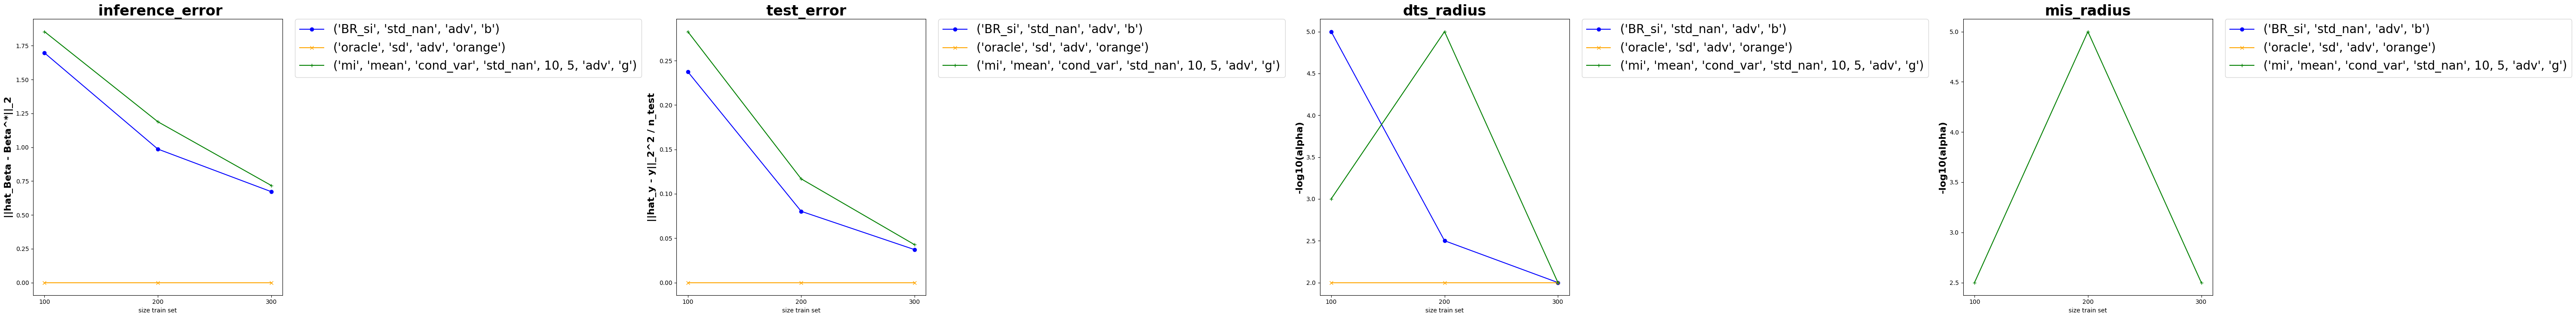

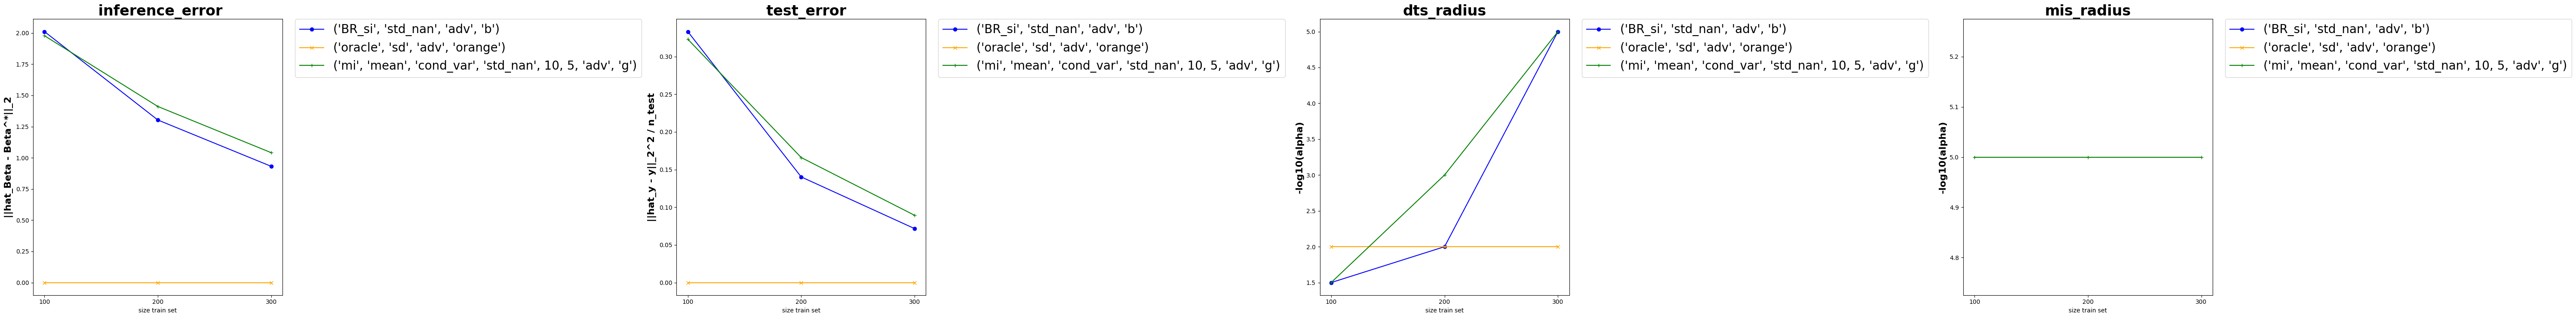

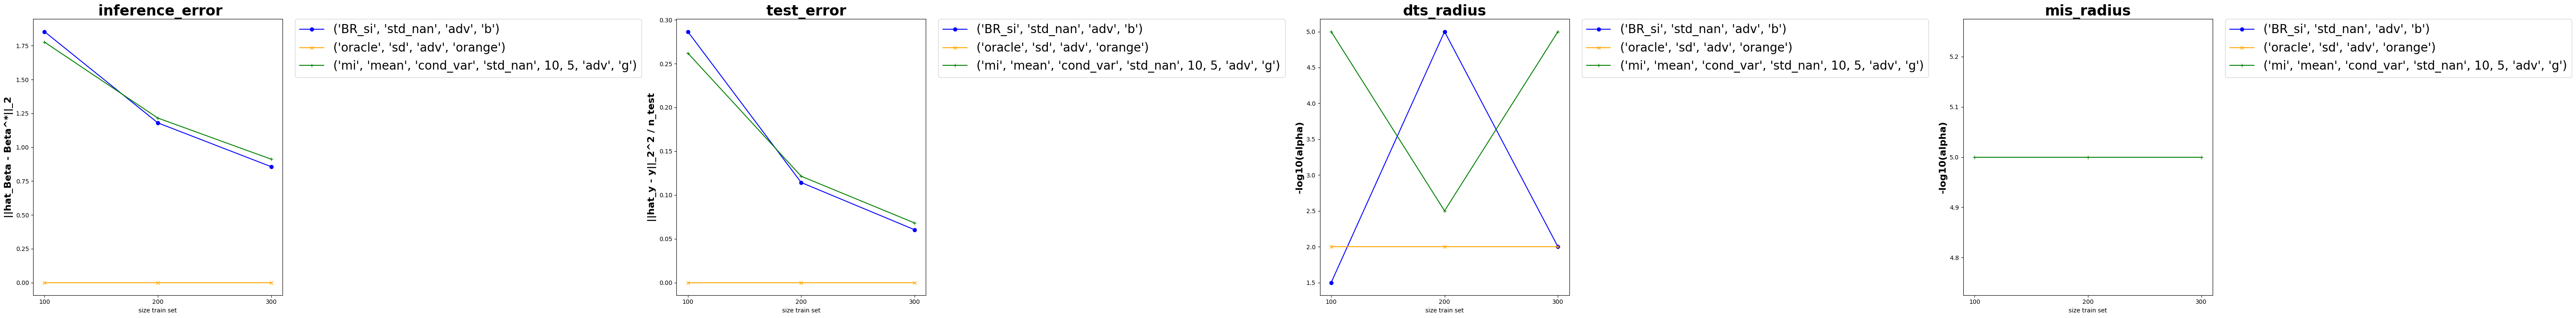

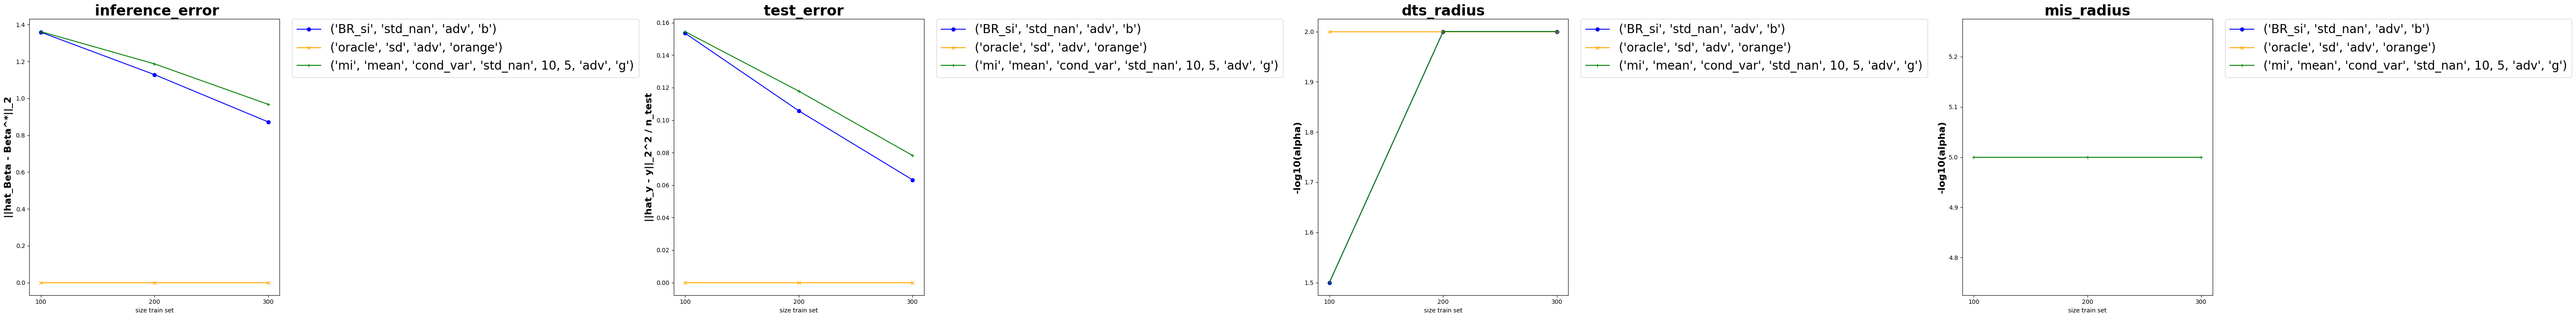

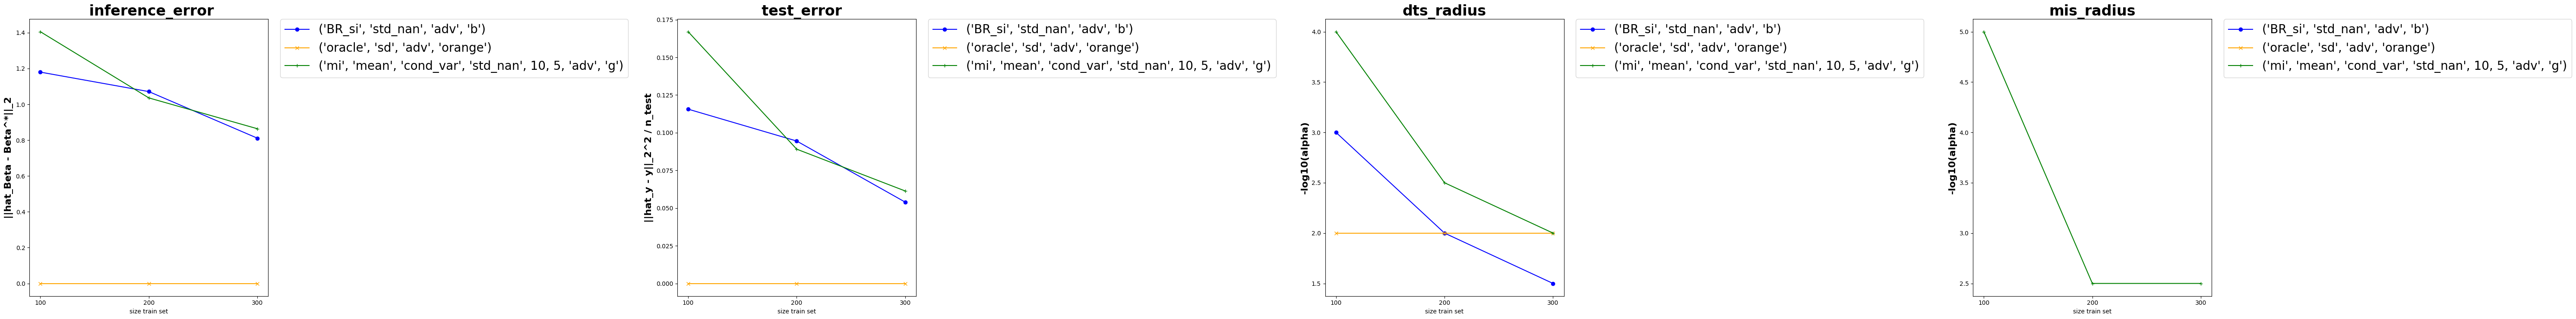

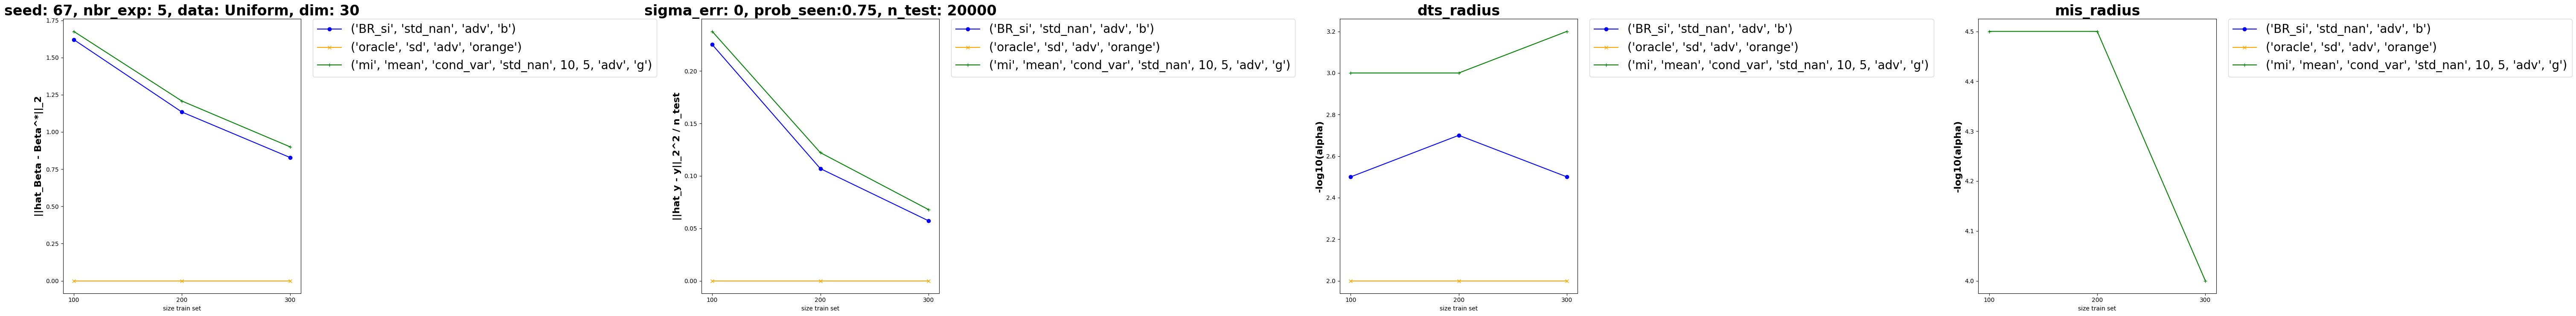

In [26]:

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
gen = 'fixed'
info_axis = 'train'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
#p_seen_both = [1, 0.9, 0.8/0.9, 0.7/0.8, 0.6/0.7, 0.5/0.6]
#p_seen_both = [1, 0.9, 0.8/0.9, 0.7/0.8, 0.6/0.7, 0.5/0.6, 0.4/0.5, 0.3/0.4]
n_train = [100, 200, 300]  # check how dataset are generated, there should be some problems with 'fixed'
lenght_vec = len(n_train)
p_seen_both = [0.75, 1, 1, 1, 1, 1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
error_vec =  [0] * length_vec
#p_seen = make_probabilities(p_seen_both)
p_seen = [p_seen_both] * length_vec
if info_axis == 'train':
  main_vec = n_train
  fix_vec = 'prob_seen:' + str(p_seen_both[0])
elif info_axis == 'p_seen':
  main_vec = np.cumprod(p_seen_both)  # p_seen_both
  fix_vec = 'n_train:' + str(n_train[0])
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)
number_test = 20000
#cov_var = 0.6
#beta_gt = np.array([-0.5, 2, 1, 3, -2, -3, 4, 0.5, 7, -9, -1, -2, -3, 4, 5, 6, 7, 8])
#beta_gt = np.array([2, 4, -0.5, 2, 1, 3, -2, -3, 4, 0.5, 7, -9, -1, -2, -3, 4])
beta_gt = np.random.randn(30)
print(beta_gt)
dim = len(beta_gt)
#nbr_feature = int(dim/2)
nbr_feature = int(np.sqrt(dim))
mean = np.array([0] * dim)
matr = np.random.randn(dim, dim) * 1
cov = matr.T @ matr + np.eye(dim) * 0.5
# np.array([[1, cov_var], [cov_var, 1]])
data_type = 'Uniform'

dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=number_test,
    data = {'data': data_type, 'mean': mean, 'cov': cov},
    beta_gt = beta_gt,
    p_miss = p_seen,
    err_vector = ['Gaussian_on_X', error_vec],
    plots = [] #['points', 'l1_vs_coef', '1/alpha_vs_coef']
)
#dicc = dicc | {'generation':gen}
dicc['what_to_plot'] = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha_dts']
dicc = dicc | {'generation': gen, 'title_infer_error':' inference_error', 'title_test_error':'  test_error'}
dicc = dicc | {'title_dts_radius': 'dts_radius', 'title_mis_radius': 'mis_radius'}
dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 100, 'adv_rad_times_delta_mis_max': 1, 'alpha_ridge_reg_max': 100,
                             'eps_adv_rad_times_delta_dts': 1e-7, 'eps_adv_rad_times_delta_mis': 1e-5, 'eps_alpha_ridge_reg': 1e-7,
                             'n_a_dts': 15, 'n_a_mis': 3, 'n_a_rid': 15}}
dicc['what_to_plot'] = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha_dts', 'best_alpha_mis']

for key, value in dicc.items():
  print(key, ": " , value)

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 10
# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):

list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'adv', 'color': 'b'},  #, 'multip_dataset': 3, 'multip_missing':0},
                         #{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'},  #, 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        #{'imp_method': 'oracle', 'cov_strategy': 'zero', 'algo_superv_learn': 'adv'},
                        #{'imp_method': 'oracle', 'cov_strategy': 'zero', 'algo_superv_learn': 'ridge'},  #, 'multip_dataset': 3, 'multip_missing': 0}
                        {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv', 'color': 'orange'},
                        #{'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'},
                        #{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'},#, 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        #{'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn':'ridge'},#, 'multip_dataset': 3, 'multip_missing': 0},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'nbr_feature': nbr_feature, 'algo_superv_learn':'adv', 'color':'g'},  #, 'multip_dataset': 3, 'multip_missing': 3},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'algo_superv_learn':'adv', 'color': 'g'}, #, 'multip_dataset': 3, 'multip_missing': 3},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'algo_superv_learn':'adv', 'color': 'r'}
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'algo_superv_learn':'adv'}
                        #{'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi', 'cov_strategy': 'std_mi', 'mi_nbr': mi_nbr},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.2},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.4},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.6},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 1},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr}#, 'multip_dataset': 3, 'multip_missing': 3}
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")

'''
nbr_exp = 2
#res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
#res[key_tuple]['best_coeff'].append(coeff_round)
#res[key_tuple]['best_score'].append(score_round)
#res[key_tuple]['best_alpha'].append(alpha_round)
res_l2 = []

rdm_seed = 4654321
np.random.seed(rdm_seed)
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)
if nbr_exp > 1:
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
    print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
    #np.random.seed(rdm_seed * (i+2))
    res_partial = run_experiments(dicc, list_methods_strategy)
    plot_res(info_x_axis, res_partial, dicc)
    print(res)
    for k in res:
      res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
      res[k]['best_score'].append(res_partial[k]['best_score'])
      res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
      #res[k]['best_coeff'].append(res_partial[k]['best_coeff
    #res.append(res['l2_dist_best_coeff_gt'])

print("final ")
print(res)
for k in res:
  print(k)
  print(np.array(res[k]['l2_dist_best_coeff_gt']))
  print(np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
  print(np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
#mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
for k, v in mean_res.items():
  print("k:   ", k)
  for s, t in v.items():
    print(s, ": ", t)
#print(np.mean(res, axis=0))
'''

nbr_exp = 5
seed = 67
mean_res = run_multiple_experiments(nbr_exp, seed, dicc, info_x_axis)
print("PLOT OF THE MEANS")
dicc['title_infer_error'] = 'seed: ' + str(seed) + ', nbr_exp: ' + str(nbr_exp) + ', data: '+ data_type + ', dim: ' + str(dim) # ', cov: ' + str(cov_var)
dicc['title_test_error'] = 'sigma_err: ' + str(error_vec[0]) + ', ' + fix_vec + ', n_test: ' + str(number_test)
#dicc['title_dts_radius'] = 'dts_radius'
#dicc['title_mis_radius'] = 'mis_radius'
#dicc = dicc | {'title_dts_radius': 'title_dts_radius', 'title_mis_radius': 'title_mis_radius'}
#dicc = dicc | {'generation':gen, 'title_infer_error':'mean_infer_error, rep: ' + str(nbr_exp), 'title_mean_error':'mean_test_error'}
#dicc['what_to_plot'] = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha_dts', 'best_alpha_mis']
plot_res(info_x_axis, mean_res, dicc)

## you can see if you manage to take the index i that maximize alpha




In [ ]:
X = np.random.randint(2, 5, size=(2, 2, 2))
print(X)

XX = np.concatenate(X)
print(XX)


Y = np.random.randint(2, 5, size=(1, 3, 2))
print(Y)

YY = np.concatenate(Y)
print(YY)


Z = np.random.randint(2, 5, size=(5, 2))
print(Z)

ZZ = np.concatenate(Z)
print(ZZ)

print("other")
s = np.random.randint(2, 4, 5)
print(s)
z = np.tile(s, reps=3)  # np.array([s] * 2)
print(z)


print("other mult")
s = np.random.randint(2, 8, size=(3, 2))
print(s)
z = np.tile(s, reps=(3, 1))  # np.array([s] * 2)
print(z)


In [ ]:
'''
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)
'''

In [ ]:
'''
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)
'''

In [ ]:
'''
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)
'''

In [ ]:
'''
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)
'''

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


# Example data
x_test_rect = np.random.rand(10)
y_test_rect = np.random.rand(10)

# Plot the points
fig, ax = plt.subplots()
ax.scatter(x_test_rect, y_test_rect)

width = 0.1
height = 0.1

#add_rectangles(x_test_rect, y_test_rect, width, height, ax)

# Add the rectangle to the plot


In [ ]:
# Cell for some tests

def test_clear_dataset(n, d):
  print("test clear dataset")
  X = np.random.randint(1, 3, size=(n, d))
  y = np.random.randint(1, 3, size=n)
  masks = np.random.binomial(1, 0.3, size=(n, d))
  print("X \n", X)
  print("y\n", y)
  print("masks \n", masks)
  masks[:, 0] = np.ones(n)
  masks[0, :] = np.ones(d)
  X_res, y_res, masks_res = clear_dataset(X, y, masks)
  print("X_res \n", X_res)
  print("y\n", y_res)
  print("masks \n", masks_res)
  print("test clear dataset ended successfully")

def test_generate_X():
    print("test generate_X started")
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf')
    gen = generate_X('circles', 2)
    data = gen(1000)
    print(data.shape)
    ax[0].scatter(data[:, 0], data[:, 1])
    print("test generate passed syccessfully")

def test_preparation_dataset(n, d):
      print("\ntest preparation dataset started")
      X_train = np.random.rand(n, d)
      print("X_train \n", X_train)
      mask = np.random.binomial(1, 0.5, (n, d))
      print("mask, 0 seen, 1 missing \n ", mask)
      X_masked = X_train * (1 - mask)
      print("X_masked \n", X_masked)
      X_nan_train = X_train.copy()
      X_nan_train[mask == 1] = np.nan
      print("X_nan_train \n", X_nan_train)
      X_br_train = single_imputation(X_nan_train, BayesianRidge())
      print("X_br_train\n ", X_br_train)

      print("what happens if we run single_imputation of full dataset")
      X_br_full = single_imputation(X_train, BayesianRidge())
      print("X_br_full\n ", X_br_full)
      np.testing.assert_allclose(X_train, X_br_full)  # shuold be untouched
      print("test preparation dataset ended successfully")

def test_listwise_delection(n, d):
    print("\n test list_wise delection started")
    X = np.random.rand(n, d)
    print("data\n", X)
    mask = np.random.binomial(1, 0.2, (n, d))
    print("mask \n", mask)
    X_ld = listwise_delection(X, mask)
    print("after calling function, X_ld \n", X_ld)

    print("edge cases, all missing")
    mask_1 = np.ones_like(X)  # all missing
    X1 = listwise_delection(X, mask_1)
    print("X1 \n", X1)  # should be empty
    mask_0 = np.zeros_like(X)  # all seen
    X0 = listwise_delection(X, mask_0)
    print("X0 \n", X0)
    np.testing.assert_allclose(X0, X)  # should be the original dataset

    print("one dimnsional array")
    y = np.random.rand(n)
    print("y before ", y)
    y_ld = listwise_delection(y, mask)
    print("y after ld ", y_ld)
    print("test listwise_delection passed")


test_generate_X()
test_preparation_dataset(3, 4)
test_listwise_delection(3, 4)
test_clear_dataset(6, 3)

xxx = np.random.randint(2, 5, size=(3, 3)) * 1.0
mmm = np.random.binomial(1, 0.5, size=(3, 3))
print(xxx)
print(mmm)
print(mmm == 1)
print(xxx[mmm == 1])
xxx[mmm == 1] = np.nan
print(xxx)
mask_from_xxx = np.isnan(xxx).astype(int)
print("mask from xxx \n", mask_from_xxx)


In [ ]:
# test best predictor

def test_best_predictor(n, d, nb_coeff):
  X_test = np.random.randint(1, 9, size=(n, d))
  beta_gt_test = np.random.randint(1, 7, size=d)
  y_test = X_test @ beta_gt_test
  #print("X_test \n", X_test, "\n beta_gt", beta_gt_test, "\n y_test = X_test @ beta_gt_test ", y_test)
  coeff_test = np.random.randint(1, 5, size=(d, nb_coeff))
  rdm_idx = np.random.randint(1, d+1, size=1)
  print(rdm_idx)
  #print("coeff test partial ", coeff_test[:, -1])
  rng = np.arange(nb_coeff)
  #print(rng != rdm_idx)
  coeff_test[:, rng != rdm_idx] = coeff_test[:, rng != rdm_idx] + 1000  # increase artificially the value of the other coefficient, to induce the minimum index to be rdm_idx
  #print("coeff_test \n", coeff_test)
  best_coeff, best_score = best_predictor(X_test, coeff_test, y_test)
  print("best coeff ", best_coeff)
  print("best score ", best_score)
  np.testing.assert_allclose(best_coeff, coeff_test[:,rdm_idx].squeeze())
  print("test best predictor passed")

test_best_predictor(100, 5, 20)




In [ ]:
# test train_and_plot

X_diab, y_diab = datasets.load_diabetes(return_X_y=True)
n, d = X_diab.shape
print("n:  ", n, ", d: ", d)
# Standardize data
X_diab -= X_diab.mean(axis=0)
X_diab /= X_diab.std(axis=0)

## original lasso
fig_l, ax_l = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_diab, y_diab)
plot_coefs_l1norm(coefs_lasso, ax_l)

## Antonio's algo, 1 matrix
S_diab_eye = np.eye(X_diab.shape[1])
fig, ax_1 = plt.subplots(1, 1, num='advtrain_linf_diab')
fig, ax_2 = plt.subplots(1, 1, num='advtrain_linf_diab_2')
train_and_plot(X_diab, y_diab, S_diab_eye, [ax_1, ax_2])

## Antonio's algo, multiple diagonal matrix
#S_diab = np.eye(X_diab.shape[1])
#S_diab = np.random.randint(1, 3, size=(n, d))
#print(S_diab)
#fig, ax_5 = plt.subplots(1, 1, num='advtrain_linf_diab_5')
#fig, ax_6 = plt.subplots(1, 1, num='advtrain_linf_diab_6')
#train_and_plot(X_diab, y_diab, S_diab, [ax_5, ax_6])


## Antonio's algo, multiple matrices (same matrix stacked multiple time)
S_diab_stacked = np.array([S_diab_eye] * X_diab.shape[0])
S_diab_stacked = np.concatenate(S_diab_stacked)
fig, ax_3 = plt.subplots(1, 1, num='advtrain_linf_diab_3')
fig, ax_4 = plt.subplots(1, 1, num='advtrain_linf_diab_4')
train_and_plot(X_diab, y_diab, S_diab_stacked, [ax_3, ax_4])




In [ ]:
# test imputations

np.random.seed(45)


def test_imputations(n, d):
  X = np.random.randint(2, 5, size=(n, d)) * 1.0
  y = X @ np.random.randint(1, 3, size=d)
  m = np.random.binomial(1, 0.4, size=(n, d))  # 1 missing, 0 seen
  print("m original\n", m)
  X, y, m = clear_dataset(X, y, m)
  print(m)
  X_nan = X.copy()
  X_nan[m == 1] = np.nan

  #mask_from_xxx = np.isnan(xxx).astype(int)
  print("X\n ", X)
  print("masks \n", m)
  print("X_nan\n ", X_nan)
  methods = ['BR_si', 'mi', 'l_d']
  nbr_mi = [1, 3]
  #for method in methods:
  #  dict_info = {'imp_method': method, 'mi_nbr':nbr_mi}
  #dict_info = {'imp_method':methods, 'mi_nbr':nbr_mi}
  for method in methods:
    print("---------- method: ", method)
    if method == 'mi':
      for x in nbr_mi:
        print("-------------------- nbr mi: ", x)
        dict_info = {'imp_method':method, 'mi_nbr':x}
        #print("XNANNANAN ", X_nan)
        X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
        print(X_res, y_res, "\n", mask_res)
    else:
      dict_info = {'imp_method': method}
      X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
      print(X_res, y_res, "\n", mask_res)
    print("test imputations ended successfully")

test_imputations(6, 3)


In [ ]:
x = []
y = np.array([1, 2])
x.append(y)
x.append(y)
x.append(y)
xx = np.stack(x)
print(x)
print(xx)
print(type(xx))


import matplotlib.pyplot as plt

sizes = [100, 1000, 10000, 100000]
values = [0.8, 0.85, 0.9, 0.92]
positions = range(len(sizes))

plt.plot(positions, values, marker='o', label='Model Accuracy')  # Add label here
plt.xticks(positions, sizes)

plt.xlabel("Dataset Size (equispaced)")
plt.ylabel("Accuracy")
plt.title("Performance vs Dataset Size (equispaced x-axis)")
#plt.legend()  # Show legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()



In [ ]:

dictio = {'a':1, 'b':2, 'c':3}
vv = dictio.values()
#print(vv)
#print(vv[1])

x1 = np.array([1, 2, 3])
x2 = np.array([3, 2 ,1])
v = np.maximum(x1, x2)
print(v)


In [ ]:
m, n, d = 2, 3, 2
x_int = np.random.randint(1, 9, (m, n, d))
print(x_int)
s = np.std(x_int, axis=0)
print(s)

# manual
print("manual computation")
x = np.zeros((m, d))
for i in range(n):
  print("i -----> ", i)
  x = x_int[:, i, :]
  print("x\n", x)
  ss = np.std(x, axis=0)
  print(ss)


print("little exp on squeeze")
sss = np.random.rand(1, 3, 3)
print(sss)
print(sss.squeeze())
print(sss.squeeze())



In [ ]:
int(34.99)

xxxx = np.random.randint(2, 4, (5, 2))
print(xxxx)
xxxx[0:2, :] = 1
print(xxxx)

print("yyyy\n")
yy = []
yy.append([1, 2, 3])
yy.append([4, 5, 6])
print(yy)
print(np.stack( yy ).T)
print("\n\n")
yyy = np.random.randint(1, 10, size=(3 , 3))
print(yyy)
yyy_a = np.array([yyy] * 2)
print(yyy_a.shape)
print(np.concatenate([yyy] * 2))
#print(np.tile(yyy_a, (2, 1, 1) ))

zzz = np.zeros((2, 2))

np.sum(np.zeros((2, 2)) == zzz)

In [ ]:

def multiple_imputation1(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


Xx = np.random.randint(1, 3, (4, 4)) * 1.0
mm = np.random.binomial(1, 0.25, (4, 4))
print(Xx)
print(mm)
Xx[mm == 1] = np.nan
print(Xx)

ice = IterativeImputer(random_state=18, max_iter=50, sample_posterior=True)
ice.fit(Xx)
XxX = np.random.randint(1, 3, (2, 4)) * 1.0
mmM = np.random.binomial(1, 0.5, (2, 4))
print(XxX)
print(mmM)
XxX[mmM == 1] = np.nan
print(XxX)

print(ice.transform(XxX))
print(ice.transform(XxX))

print("new")

ls = [[[]],[[]]]
print(ls)
ls[0][0]



In [ ]:
import numpy as np

XX = np.random.randint(1, 7, (2, 3, 3))
print(XX)
XXX = np.tile(XX, (2, 1, 1))
print(XXX)

print(np.zeros(2))

y_o = np.array([1, 2])
y_oo = np.tile(y_o, 3)
print(y_oo)


In [ ]:
import numpy as np
def generate_masks_binomial_general(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks


#mm = np.random.binomial(1, [[0.2, 0.2, 0.2], [0.8, 0.8, 0.8]], (2, 3, 3))
#print(mm)
cc = np.array([np.random.binomial(1, x, (4, 4)) for x in [0.2, 0.2, 0.2]])
print(cc)
s_cc = np.cumsum(cc, axis=0)
print(s_cc)
s_cc[s_cc>1] = 1
print(s_cc)

s_v = np.random.randint(1, 4, (3, 4))
print(s_v)
s_vv = s_v[:, None, :] * np.eye(4)
print(s_vv)









In [ ]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import ridge_regression

X = np.random.randn(100, 4) #rng.randn(100, 4)

y = 2.0 * X[:, 0] - 1.0 * X[:, 1] + 0.1 * np.random.randn(100)
np.random.seed(4)
alphas = [0.00001, 0.001, 0.1, 1]
estim = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=False, random_state=0)
for a in alphas:
  #coef, intercept = estim(X, y, a)
  coef = estim(X, y, a)
  print("coef : ", coef)
  #print("intercpt ", intercept)
  coef, intercept = ridge_regression(X, y, alpha=a, return_intercept=True, random_state=0)
  #print("coef : ", coef)
  #print("intercpt ", intercept)


lg = np.random.logistic(loc=0.0, scale=1.0, size=(4, 3))
print("log res ", lg)



In [2]:
!pip install gcimpute

In [ ]:
from gcimpute.low_rank_gaussian_copula import LowRankGaussianCopula
import numpy as np

# Generate some sample data with missing values
X_with_nan = np.random.rand(100, 10)
mask = np.random.binomial(1, 0.2, size=X_with_nan.shape).astype(bool)
X_with_nan[mask] = np.nan

# Create an instance of LowRankGaussianCopula
# rank: the rank of the low-rank approximation
# max_iter: maximum number of iterations for the optimization
# tol: tolerance for convergence
# verbose: whether to print progress
gc_imputer = LowRankGaussianCopula(rank=5, max_iter=100, tol=1e-4, verbose=True)

# Fit the imputer on the data and transform it to impute missing values
X_imputed = gc_imputer.fit_transform(X_with_nan)

print("Original data shape:", X_with_nan.shape)
print("Imputed data shape:", X_imputed.shape)
print("Number of NaNs in original data:", np.isnan(X_with_nan).sum())
print("Number of NaNs in imputed data:", np.isnan(X_imputed).sum())

In [1]:
import gcimpute
print(gcimpute.__version__)

0.0.4
